<a href="https://colab.research.google.com/github/wirriamm/es3302-btnr/blob/main/bukit_timah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
def process_species(filepath, parent_cutoff=50, child_cutoff=30):
  """Return 2 df of parents and children filtered by dbh"""
  raw_df = pd.read_csv(filepath)
  df = raw_df[(raw_df['status'] == 'A') & (raw_df['dbh'].notna())]
  parents = df.loc[df['dbh'] > parent_cutoff, ['gx','gy','dbh','quadrat']].reset_index(drop=True)
  children = df.loc[df['dbh'] < child_cutoff, ['gx','gy','dbh','quadrat']].reset_index(drop=True)
  process_parents(parents, children)
  return parents, children

def within_radius(row, x0, y0, radius):
  x1, y1 = row.gx, row.gy
  return ((x1-x0)**2 + (y1-y0)**2 <= radius**2)

def count_children_within(row, radius, children):
  return children.apply(within_radius, axis=1, args=(row.gx, row.gy, radius)).sum()

def count_oth_parents_within(row, radius, parents):
  return parents.apply(within_radius, axis=1, args=(row.gx, row.gy, radius)).sum()
  # Don't Minus itself, avoid infinity normalised counts

def process_parents(parents, children):
  # Add cols: number of children within radius r, [10,80]
  for r in range(10,90,10):
    parents[f"c{r}"] = parents.apply(count_children_within, axis=1, args=[r, children])
  # Add cols: number of fellow parents within 1.5r, [10,80]
  for r in range(10,90,10):
    parents[f"p{r}"] = parents.apply(count_oth_parents_within, axis=1, args=[1.5*r, parents])
  # Add cols: number of normalized children within r, [10,80]
  for r in range(10,90,10):
    parents[f"n{r}"] = parents[f"c{r}"] / parents[f"p{r}"]
  return parents

In [3]:
primary = {
    'SHORCU': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/pri4_shorcu.csv"
    },
    'DIPTCA': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/pri4_diptca.csv"
    },
    'HOPEME': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/pri4_hopeme.csv"
    },
    'GLUTWA': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/pri4_glutwa.csv"
    },
    'KOOMMA': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/pri4_koomma.csv"
    }
}

secondary = {
    'SHORCU': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/sec2_shorcu.csv"
    },
    'DIPTCA': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/sec2_diptca.csv"
    },
    'HOPEME': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/sec2_hopeme.csv"
    },
    'GLUTWA': {
        'filepath': "/content/drive/My Drive/Y3S1/ES3302/sec2_glutwa.csv"
    }
}

In [4]:
for key, value in primary.items():
  primary[key]['parents'], primary[key]['children'] = process_species(value['filepath'])
for key, value in secondary.items():
  secondary[key]['parents'], secondary[key]['children'] = process_species(value['filepath'])

In [5]:
# primary['SHORCU']['parents']

# Diff radius

In [6]:
spe = 'SHORCU'
pri_raw_means = []
sec_raw_means = []
pri_norm_means = []
sec_norm_means = []
pri_par_means = []
sec_par_means = []
for i in range(10,90,10):
  pri_raw_means.append(primary[spe]['parents'][f"c{i}"].mean())
  sec_raw_means.append(secondary[spe]['parents'][f"c{i}"].mean())
  pri_norm_means.append(primary[spe]['parents'][f"n{i}"].mean())
  sec_norm_means.append(secondary[spe]['parents'][f"n{i}"].mean())
  pri_par_means.append(primary[spe]['parents'][f"p{i}"].mean())
  sec_par_means.append(secondary[spe]['parents'][f"p{i}"].mean())

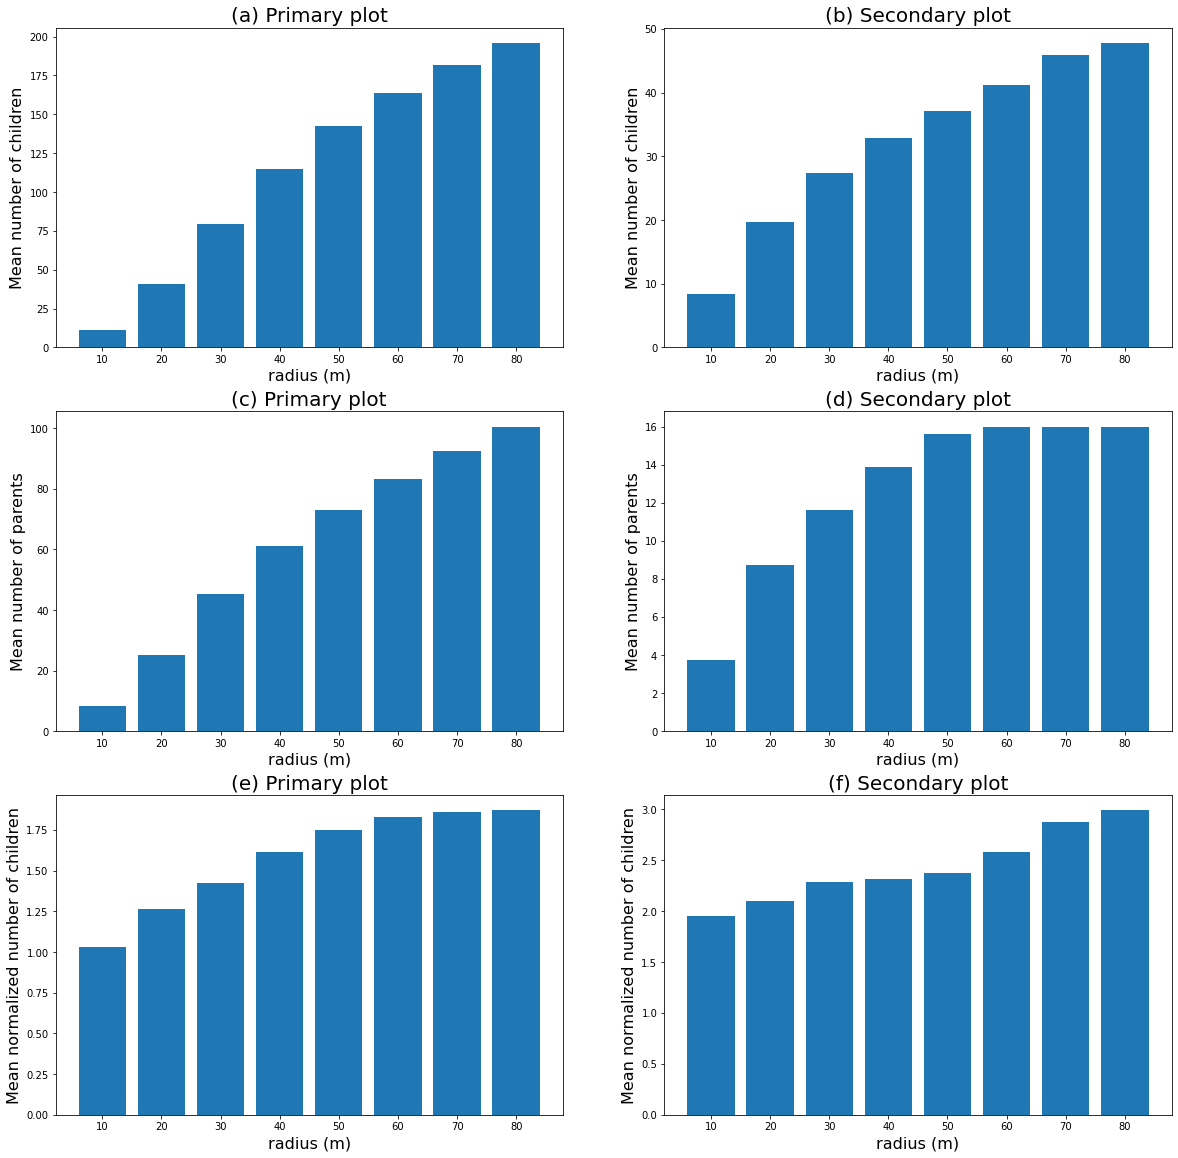

In [7]:
fig, ax = plt.subplots(nrows=3,ncols=2) # figsize=(30,30)
x_axes = [f"{i}" for i in range(10,90,10)]
ax[0,0].bar(x_axes, pri_raw_means)
ax[1,0].bar(x_axes, pri_par_means)
ax[2,0].bar(x_axes, pri_norm_means)
ax[0,1].bar(x_axes, sec_raw_means)
ax[1,1].bar(x_axes, sec_par_means)
ax[2,1].bar(x_axes, sec_norm_means)

ax[0,0].set_title("(a) Primary plot", fontsize=20)
ax[1,0].set_title("(c) Primary plot", fontsize=20)
ax[2,0].set_title("(e) Primary plot", fontsize=20)
ax[0,1].set_title("(b) Secondary plot", fontsize=20)
ax[1,1].set_title("(d) Secondary plot", fontsize=20)
ax[2,1].set_title("(f) Secondary plot", fontsize=20)

ax[0,0].set_ylabel("Mean number of children", fontsize=16)
ax[1,0].set_ylabel("Mean number of parents", fontsize=16)
ax[2,0].set_ylabel("Mean normalized number of children", fontsize=16)
ax[0,1].set_ylabel("Mean number of children", fontsize=16)
ax[1,1].set_ylabel("Mean number of parents", fontsize=16)
ax[2,1].set_ylabel("Mean normalized number of children", fontsize=16)

ax[0,0].set_xlabel("radius (m)", fontsize=16)
ax[1,0].set_xlabel("radius (m)", fontsize=16)
ax[2,0].set_xlabel("radius (m)", fontsize=16)
ax[0,1].set_xlabel("radius (m)", fontsize=16)
ax[1,1].set_xlabel("radius (m)", fontsize=16)
ax[2,1].set_xlabel("radius (m)", fontsize=16)

fig.set_size_inches(20,20)
plt.show()

# Plot by quadrat

## Quadrat functions

In [8]:
def char_range(start, end):
  i, j = ord(start), ord(end)
  return [chr(x) for x in range(i, j+1)]

def char_range2_iter(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2)+1):
        yield chr(c)

def heatmap_ar(dic, spe='SHORCU', col='c20'):
  # spe = 'SHORCU'
  # col = 'c20'
  # dic = primary
  chars = char_range('A','J') if dic == primary else char_range('K', 'T')
  quadrat = dic[spe]['parents'].groupby('quadrat').mean()[col]
  return [[quadrat.get(f"{c}{n}", default=0) for c in chars] for n in range(1,6)]

# heatmap_ar(primary, 'SHORCU', 'c20')
# heatmap_ar(secondary, 'SHORCU', 'c20')

def plot_heatmap(dic, spe='SHORCU', col='c20', title=""):
  data = heatmap_ar(dic, spe, col)
  chars = char_range('A','J') if dic == primary else char_range('K', 'T')
  norm = "(Normalized) " if col == 'n20' else ""
  fig, ax = plt.subplots(figsize=(10,4), dpi=400)
  ax = sns.heatmap(data, annot=True, cmap="YlGnBu", yticklabels=range(1,6), xticklabels=chars,
                   cbar_kws={'label': f"{norm}Mean children density"}, vmin=0)
  ax.set_title(title, fontsize=11)
  plt.show()

## SHORCU

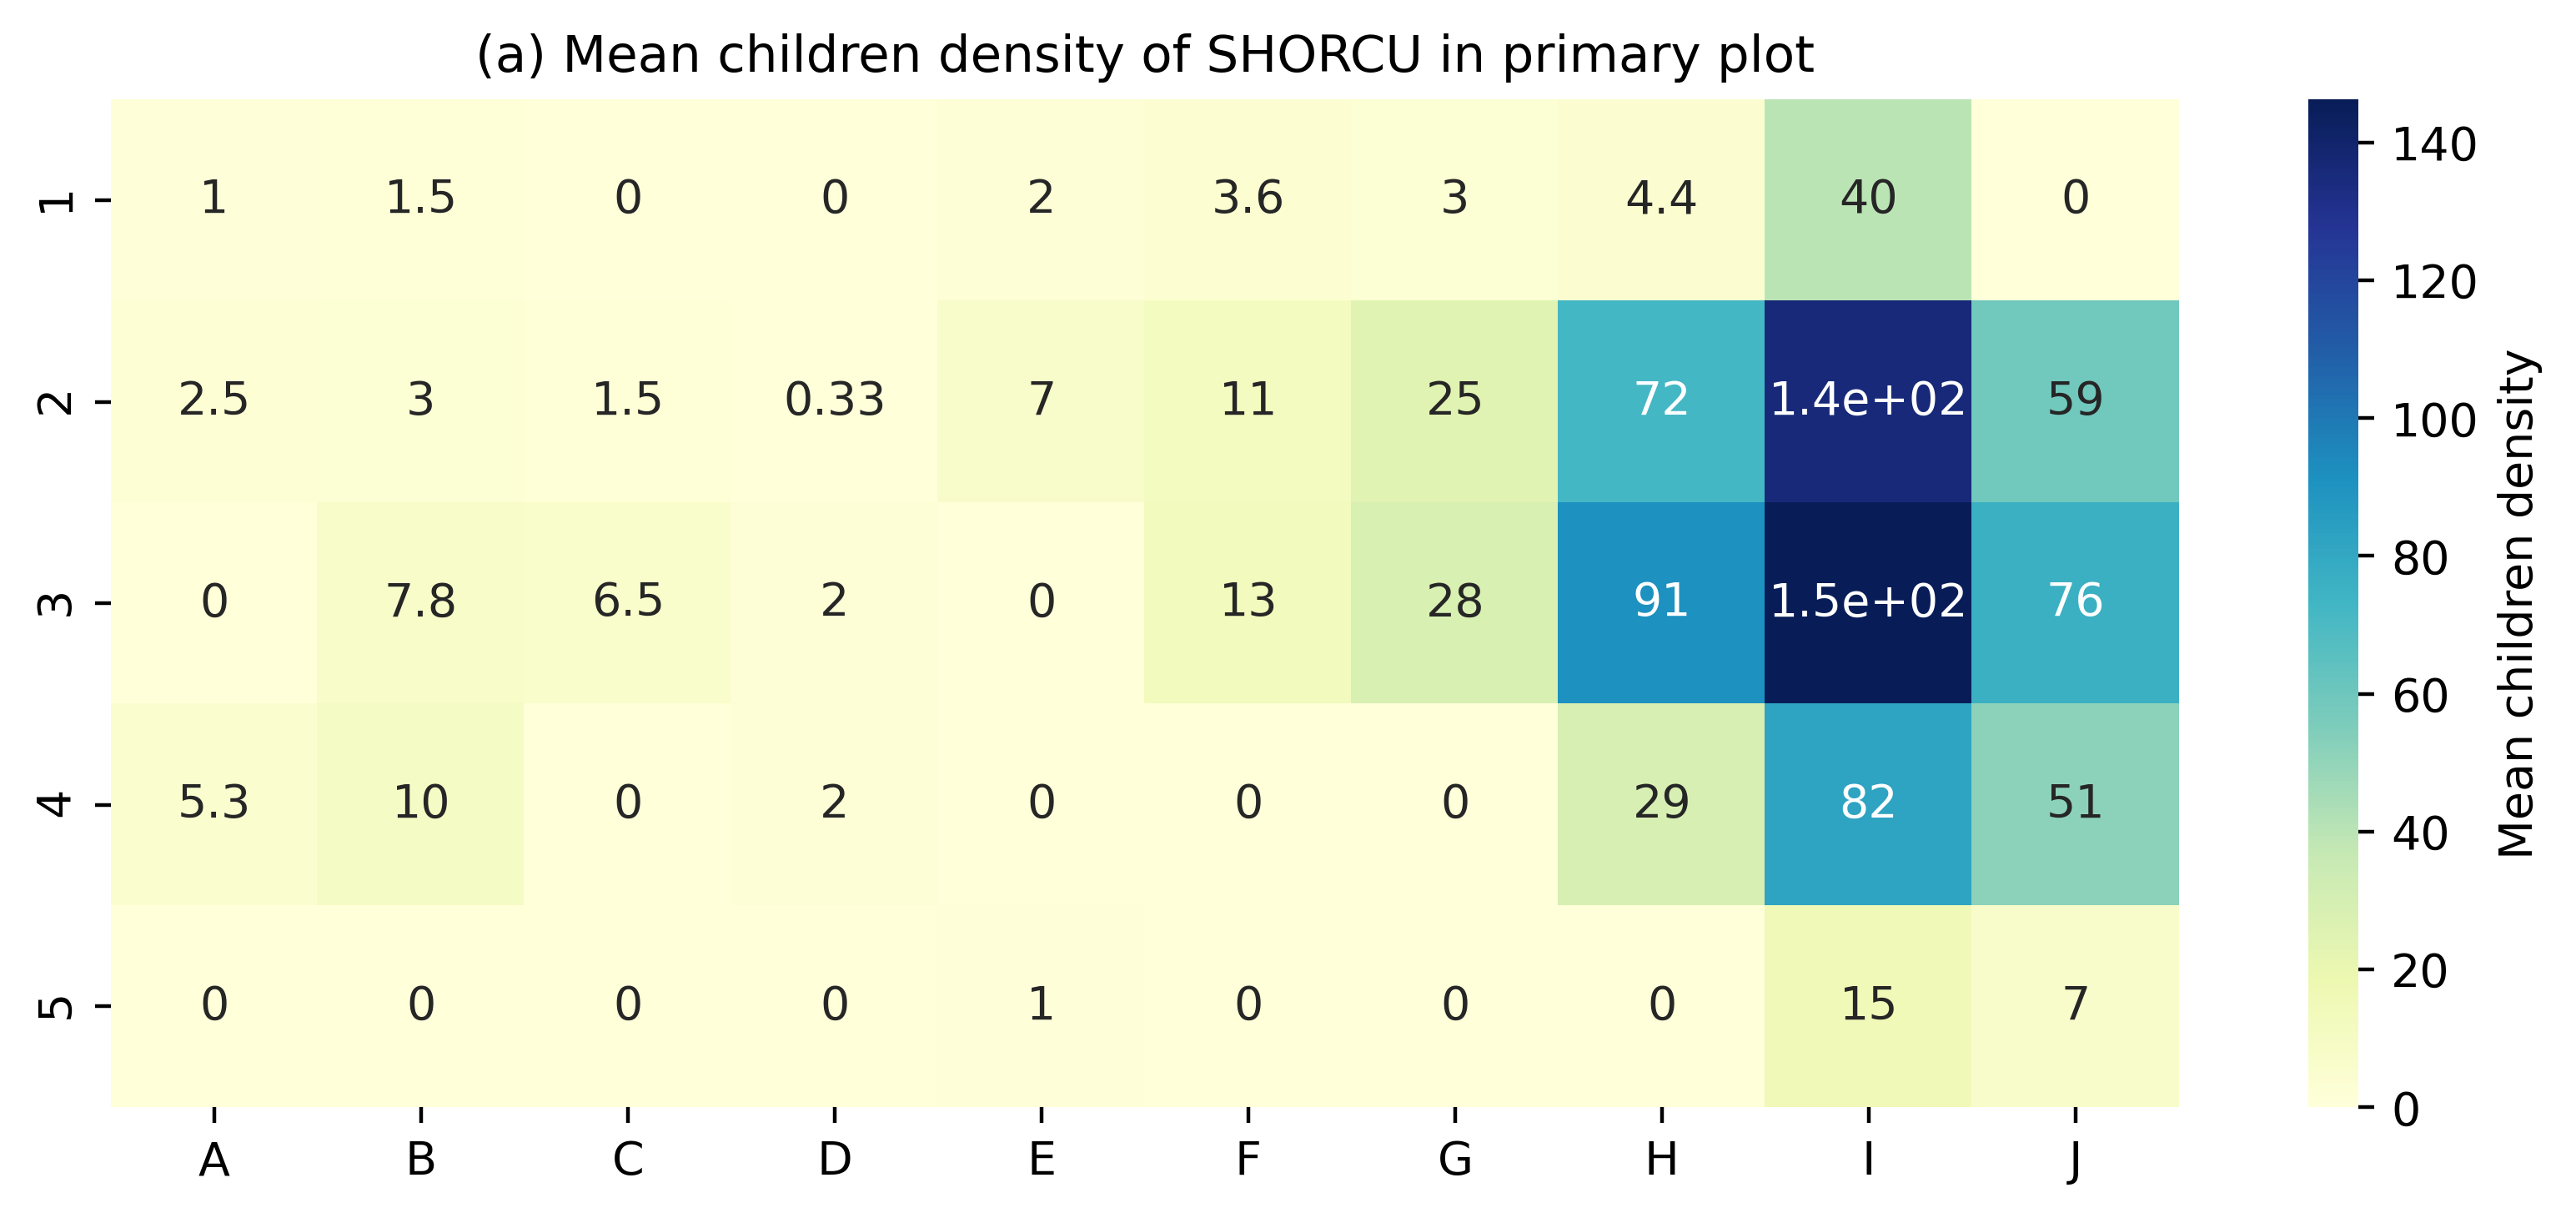

In [9]:
plot_heatmap(primary, 'SHORCU', 'c20', "(a) Mean children density of SHORCU in primary plot")

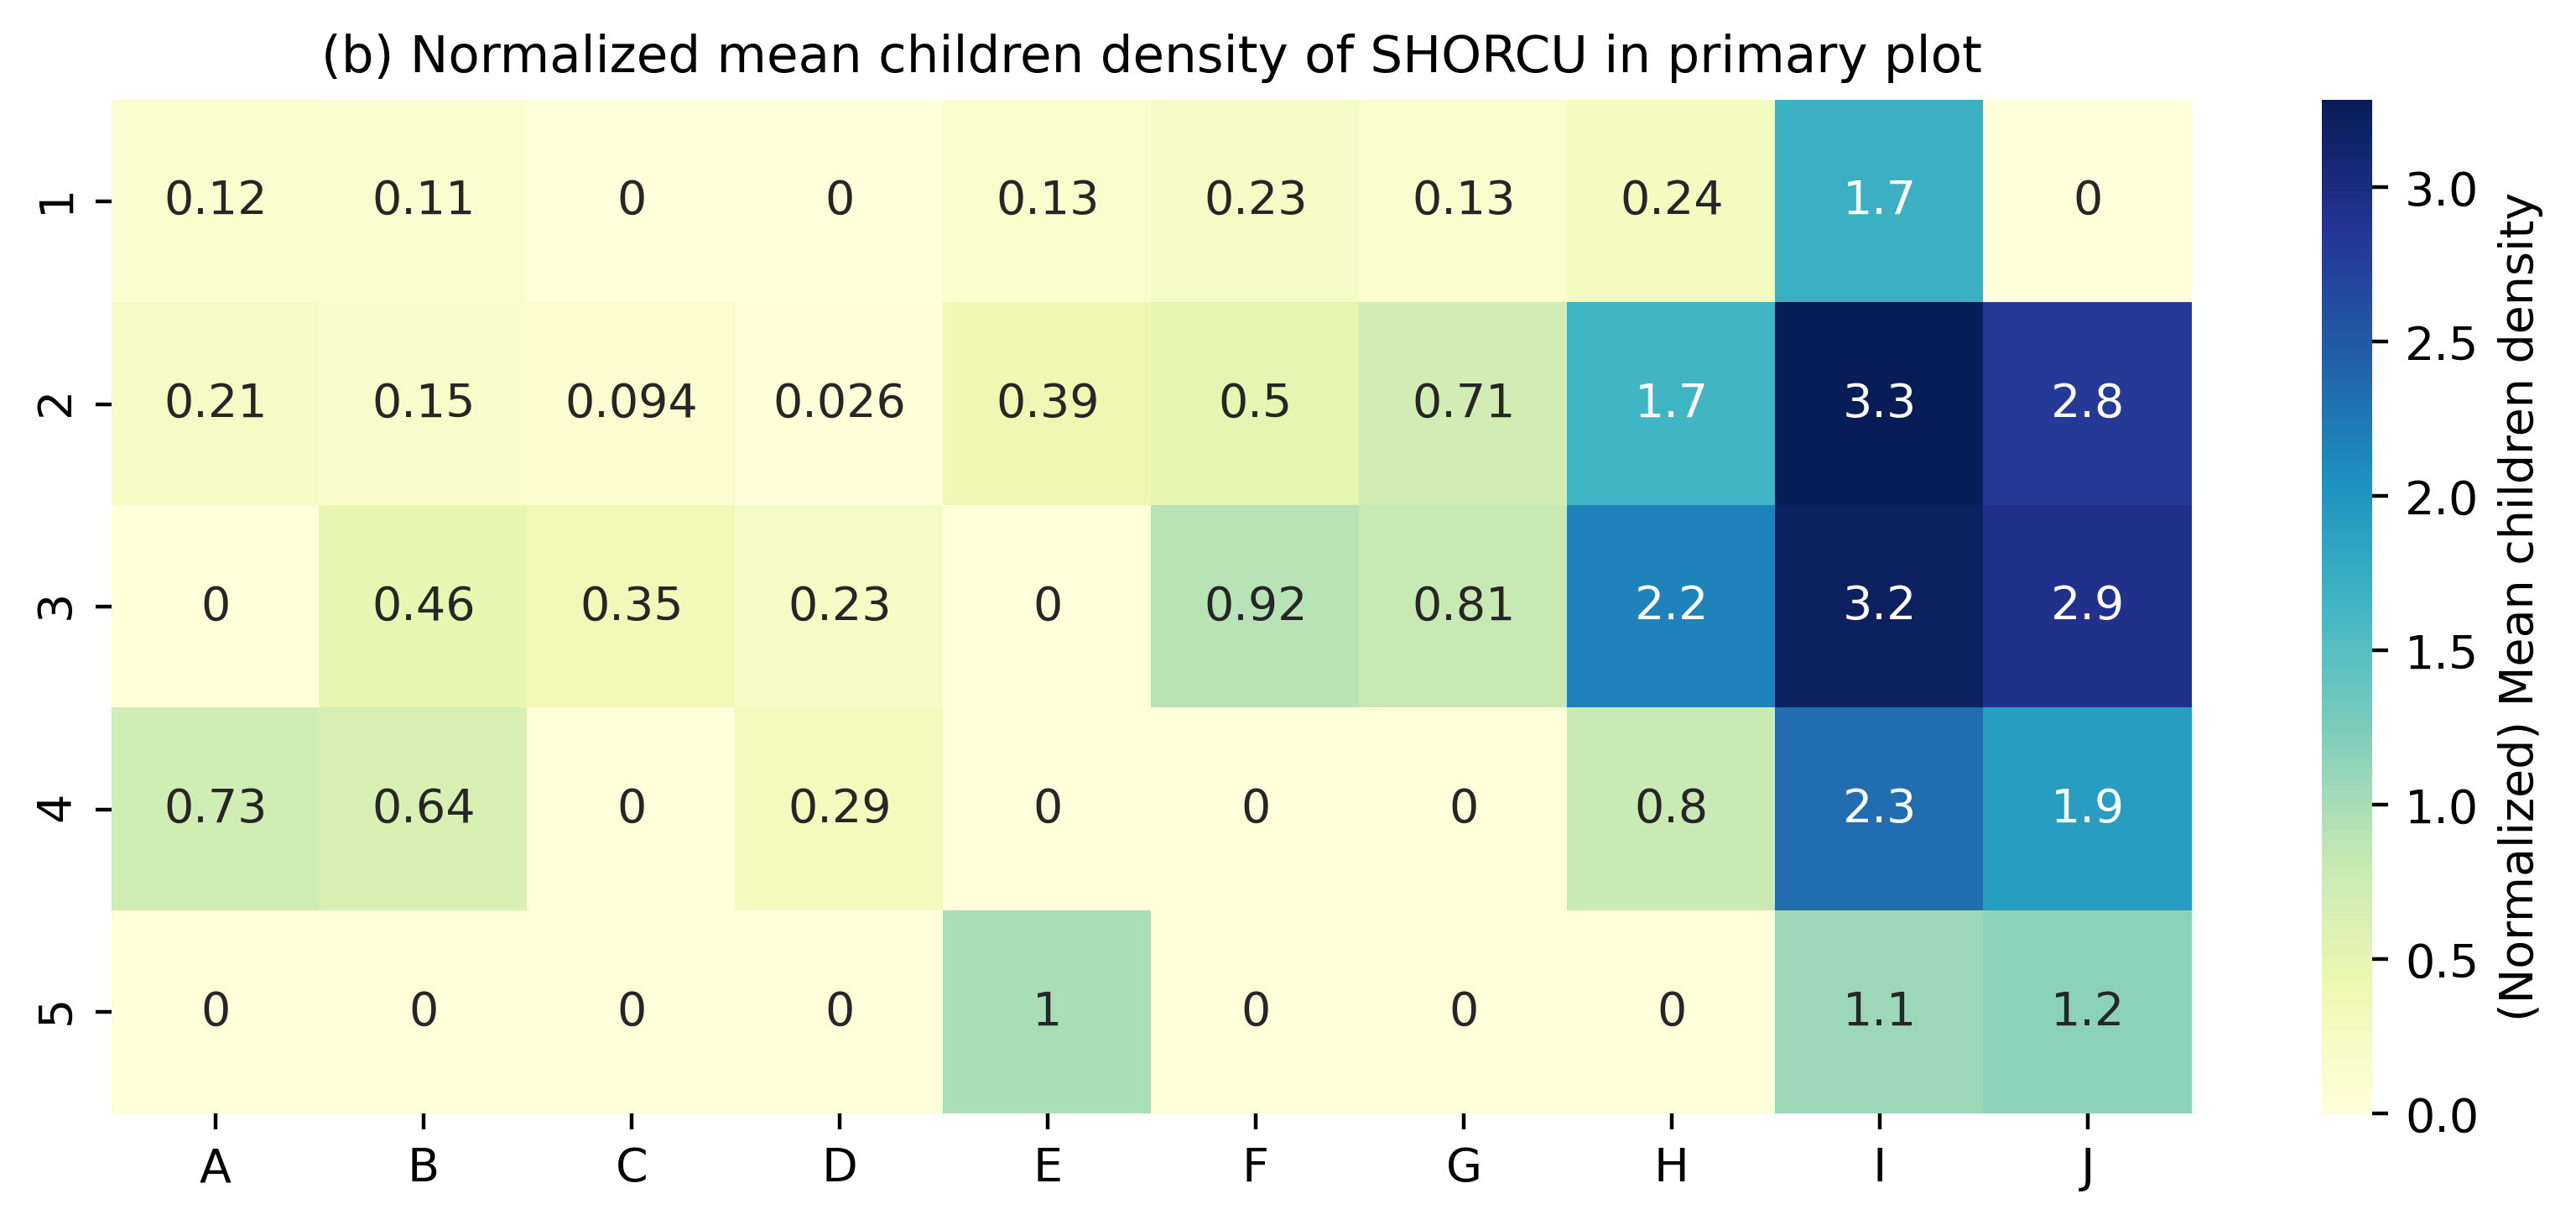

In [10]:
plot_heatmap(primary, 'SHORCU', 'n20', "(b) Normalized mean children density of SHORCU in primary plot")

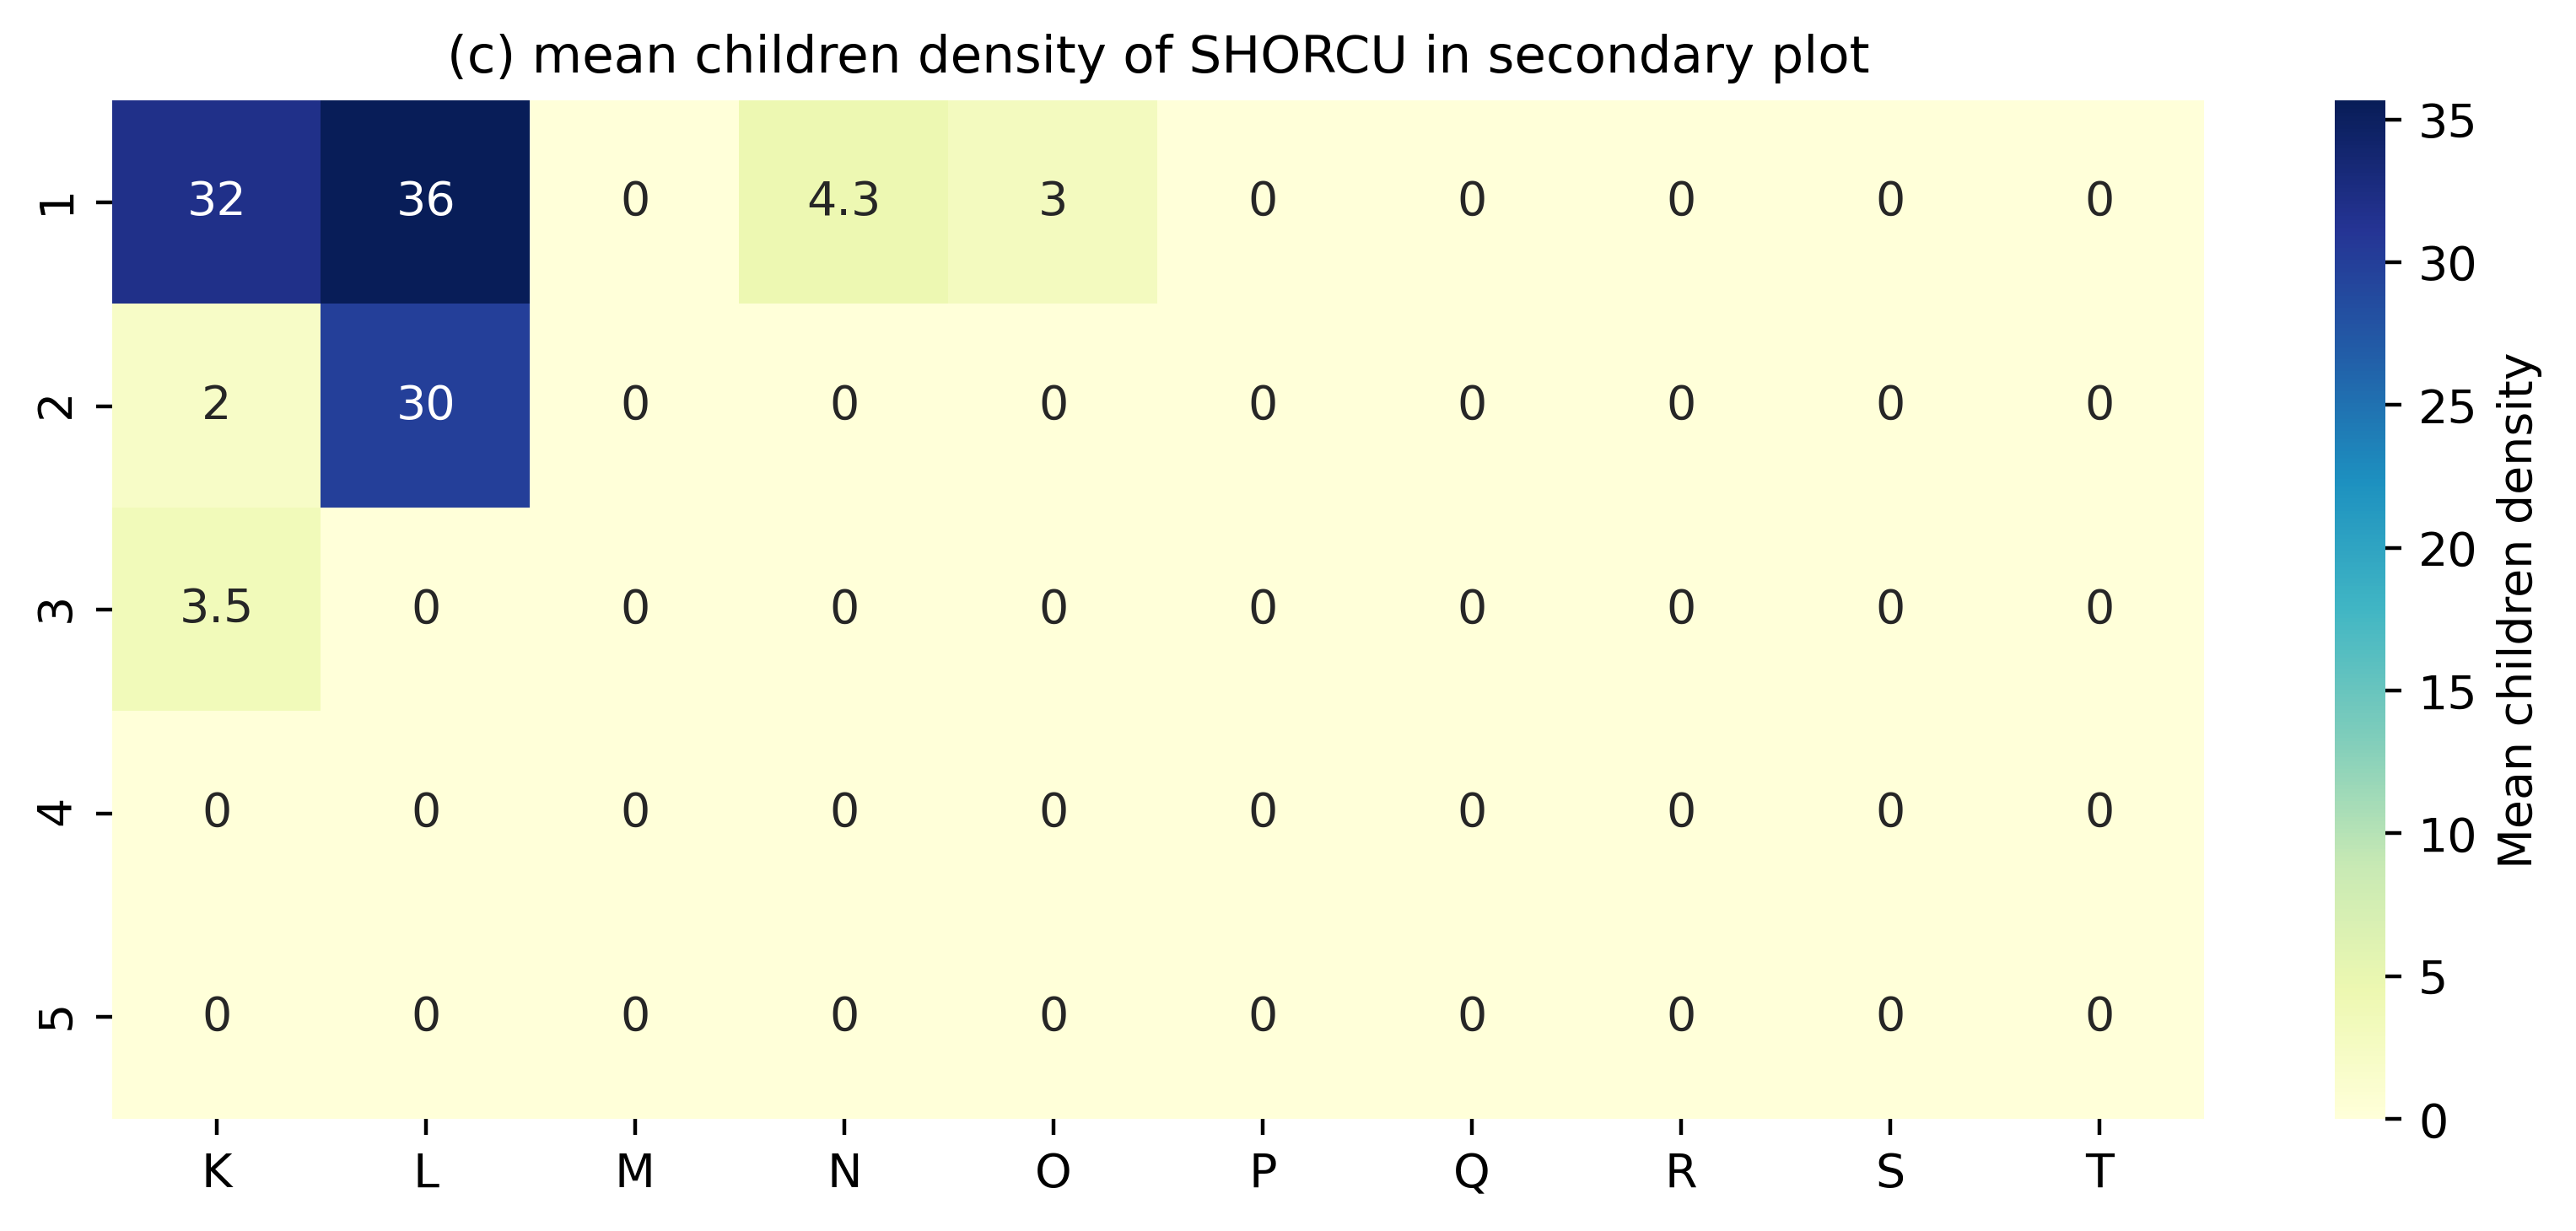

In [11]:
plot_heatmap(secondary, 'SHORCU', 'c20', "(c) mean children density of SHORCU in secondary plot")

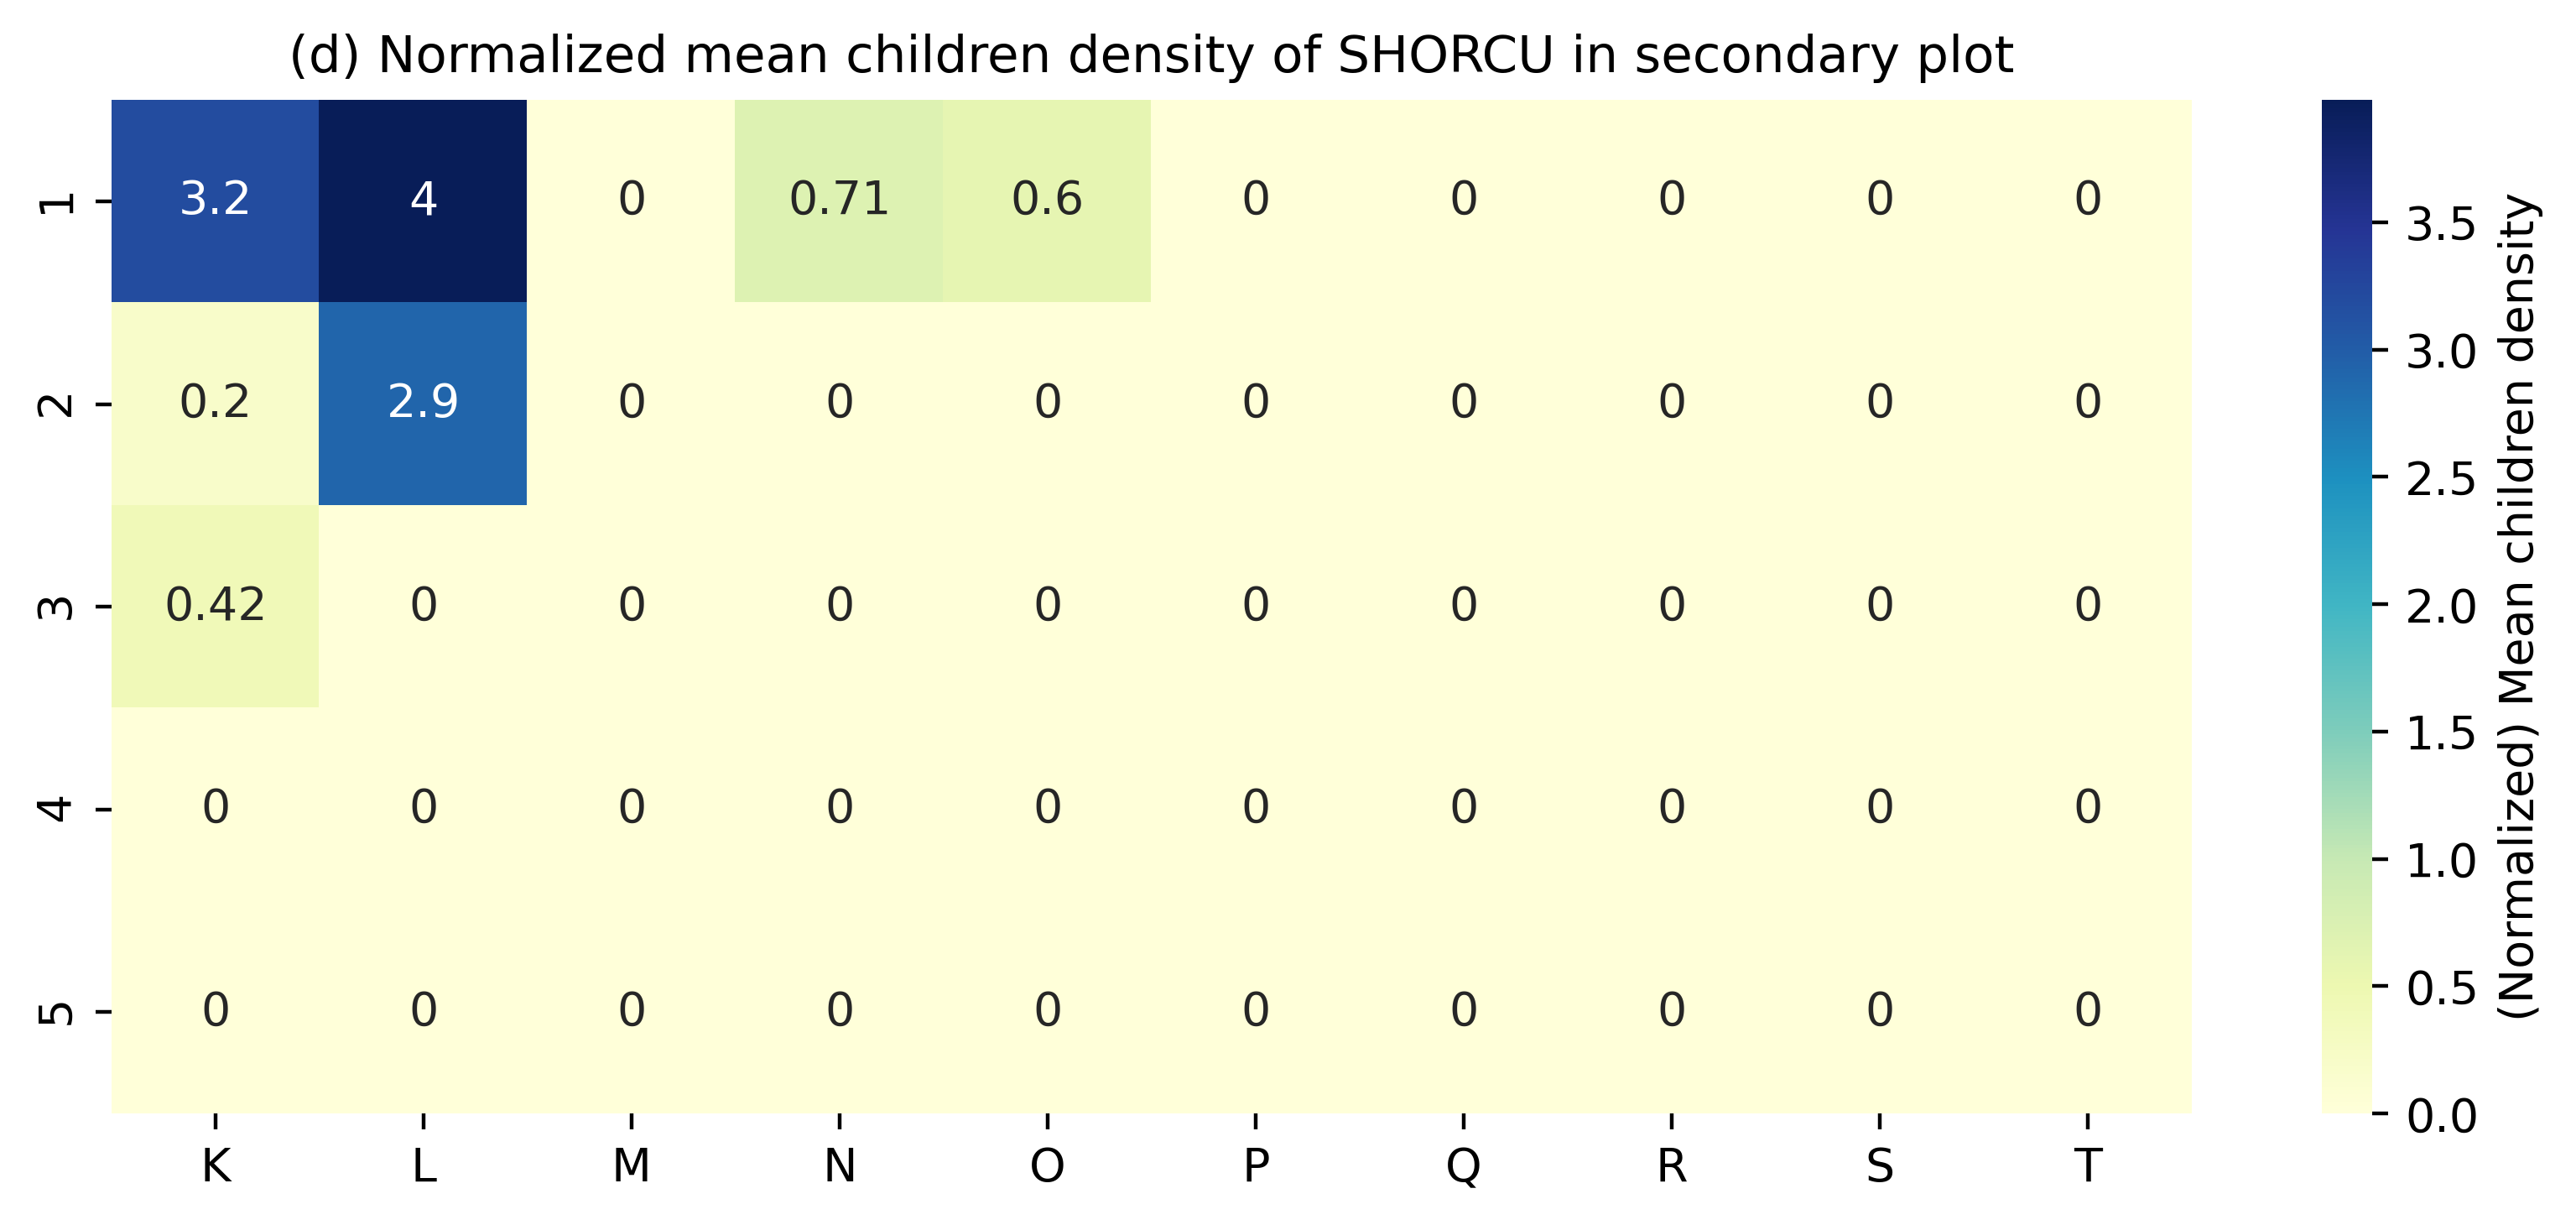

In [12]:
plot_heatmap(secondary, 'SHORCU', 'n20', "(d) Normalized mean children density of SHORCU in secondary plot")

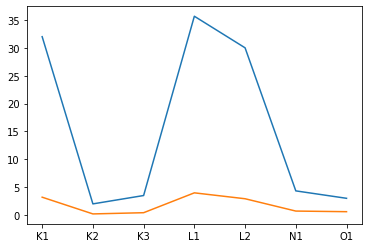

In [13]:
df = secondary['SHORCU']['parents'].groupby('quadrat').mean()[['c20', 'n20']]
plt.plot(df)
plt.show()

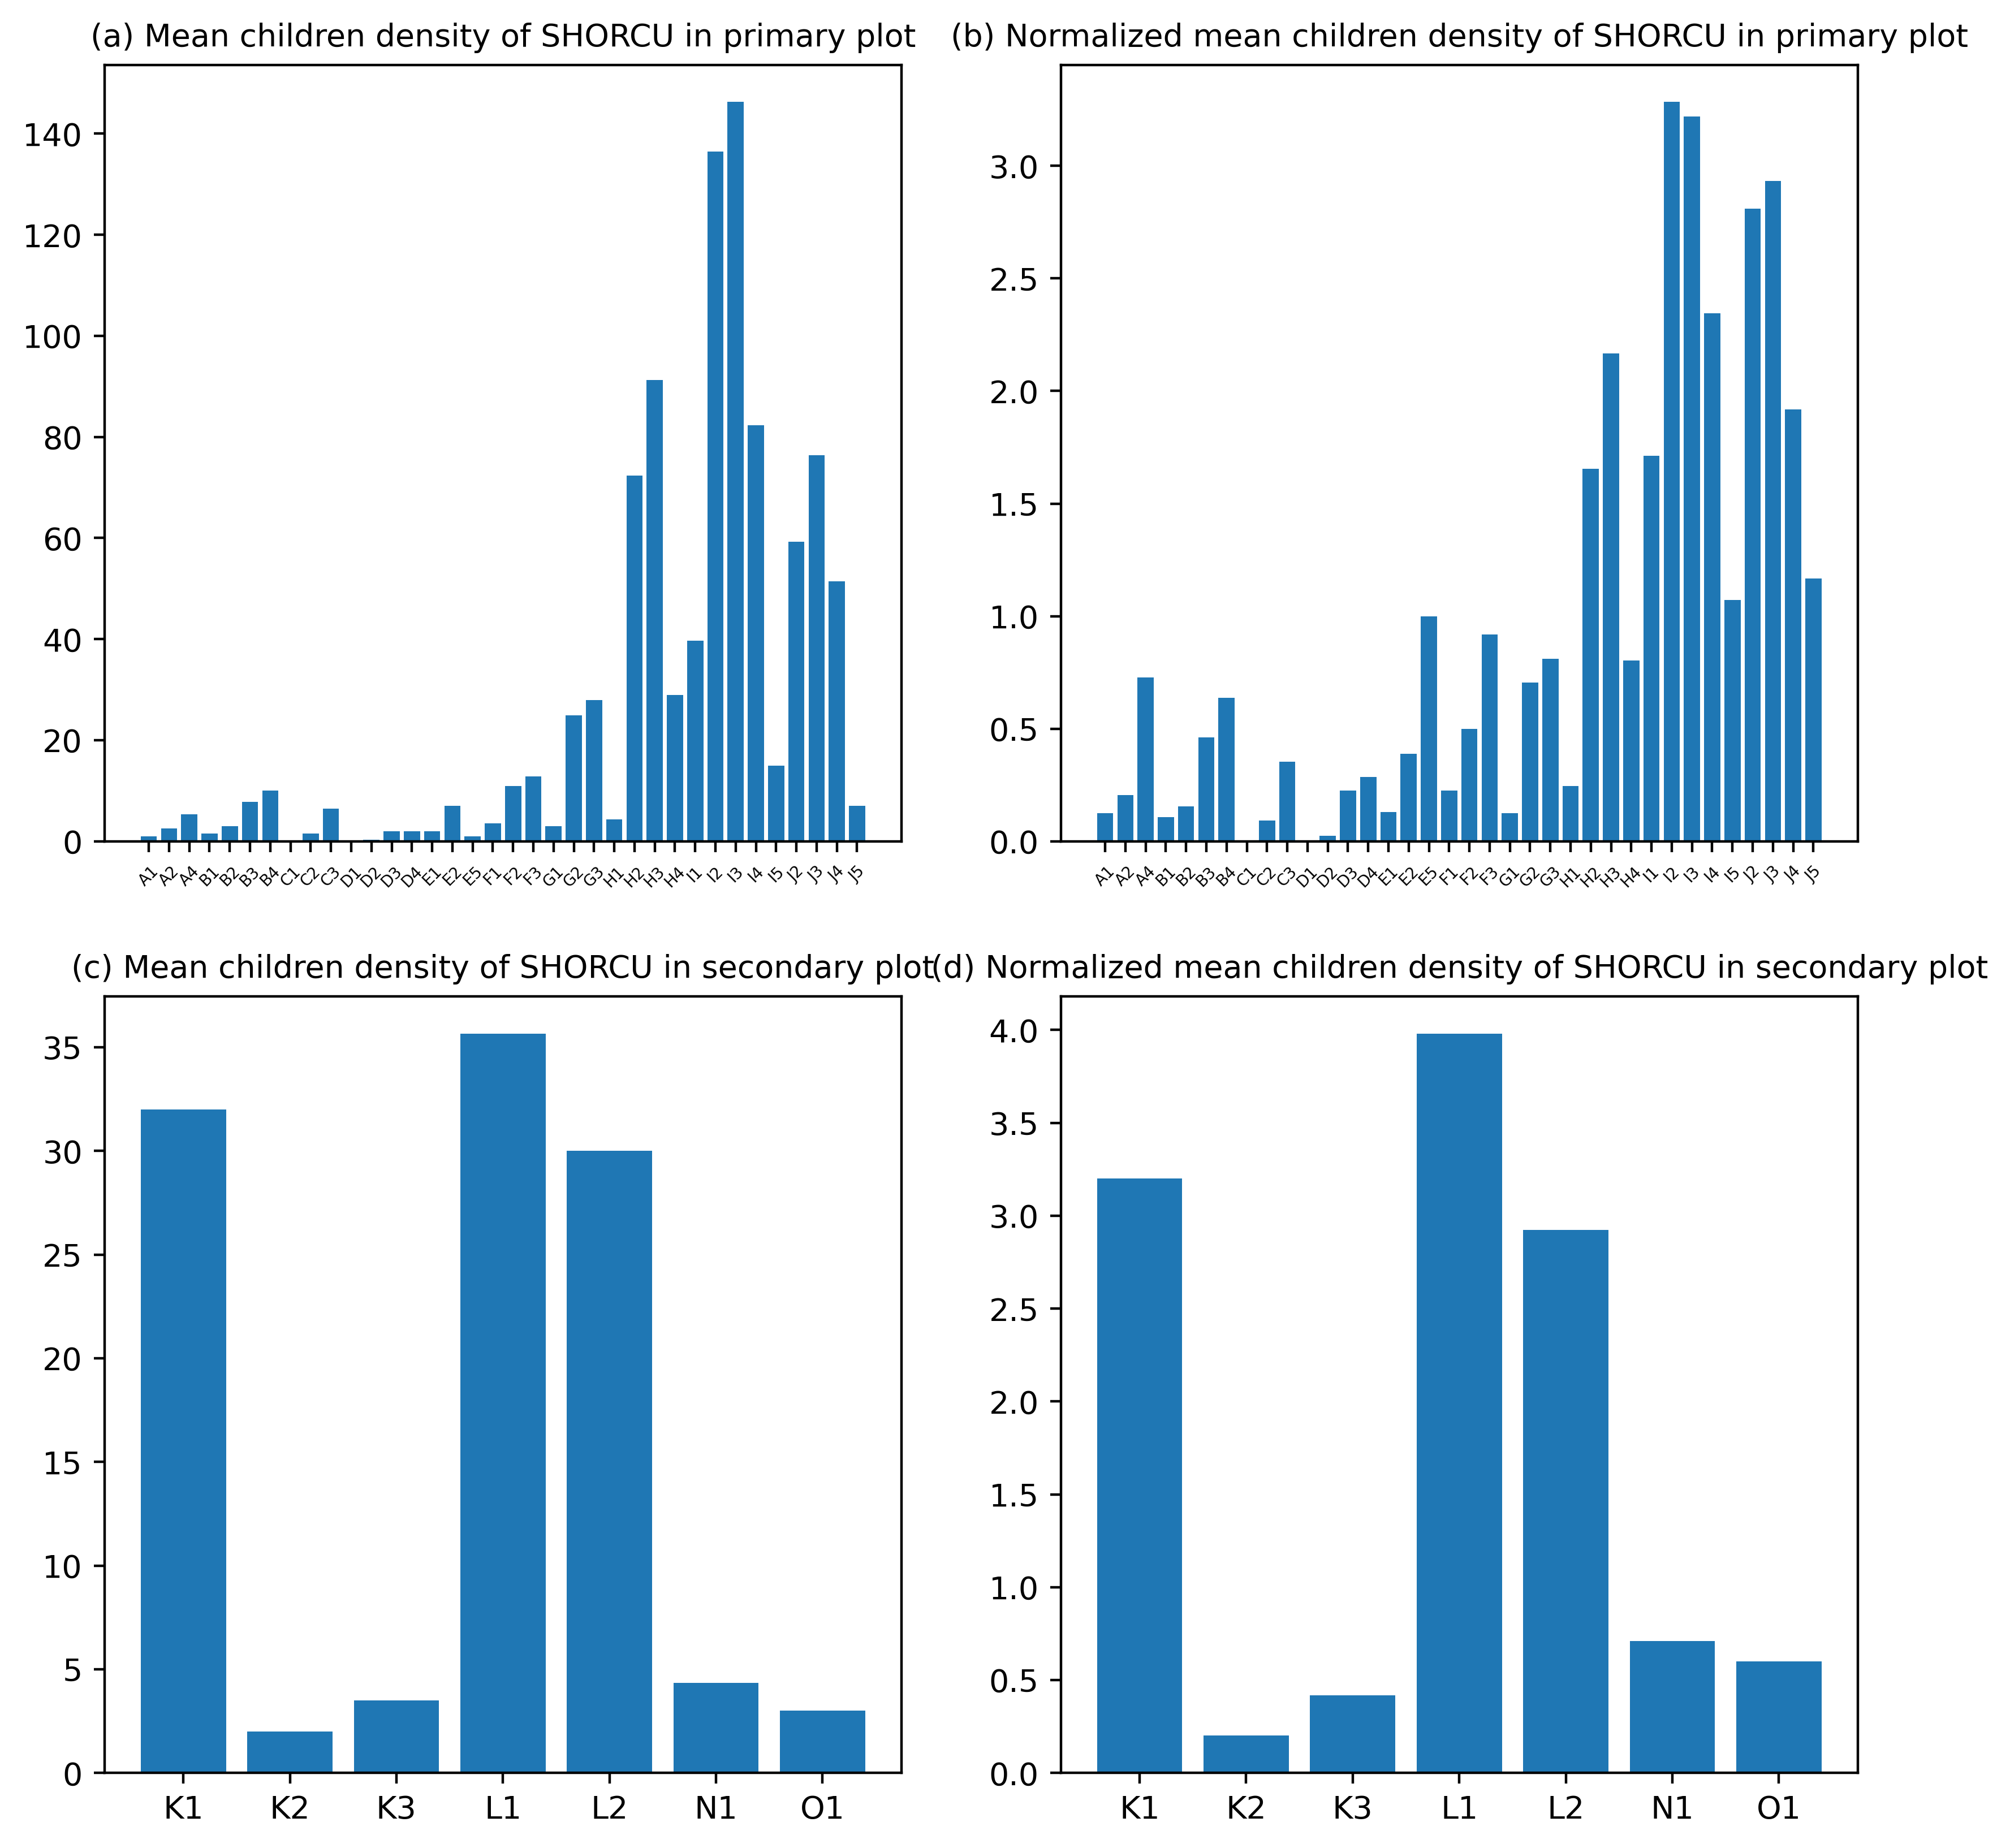

In [14]:
pri = primary['SHORCU']['parents'].groupby('quadrat').mean()[['c20', 'n20']]
sec = secondary['SHORCU']['parents'].groupby('quadrat').mean()[['c20', 'n20']]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=400)
ax[0,0].bar(pri.index, pri['c20'])
ax[0,1].bar(pri.index, pri['n20'])
ax[1,0].bar(sec.index, sec['c20'])
ax[1,1].bar(sec.index, sec['n20'])

ax[0,0].set_title("(a) Mean children density of SHORCU in primary plot", fontsize=10)
ax[0,1].set_title("(b) Normalized mean children density of SHORCU in primary plot", fontsize=10)
ax[1,0].set_title("(c) Mean children density of SHORCU in secondary plot", fontsize=10)
ax[1,1].set_title("(d) Normalized mean children density of SHORCU in secondary plot", fontsize=10)

for x in ax[0,0].get_xticklabels():
  x.set_rotation(45)
  x.set_fontsize(5)
for x in ax[0,1].get_xticklabels():
  x.set_rotation(45)
  x.set_fontsize(5)
plt.show()

## GLUTWA

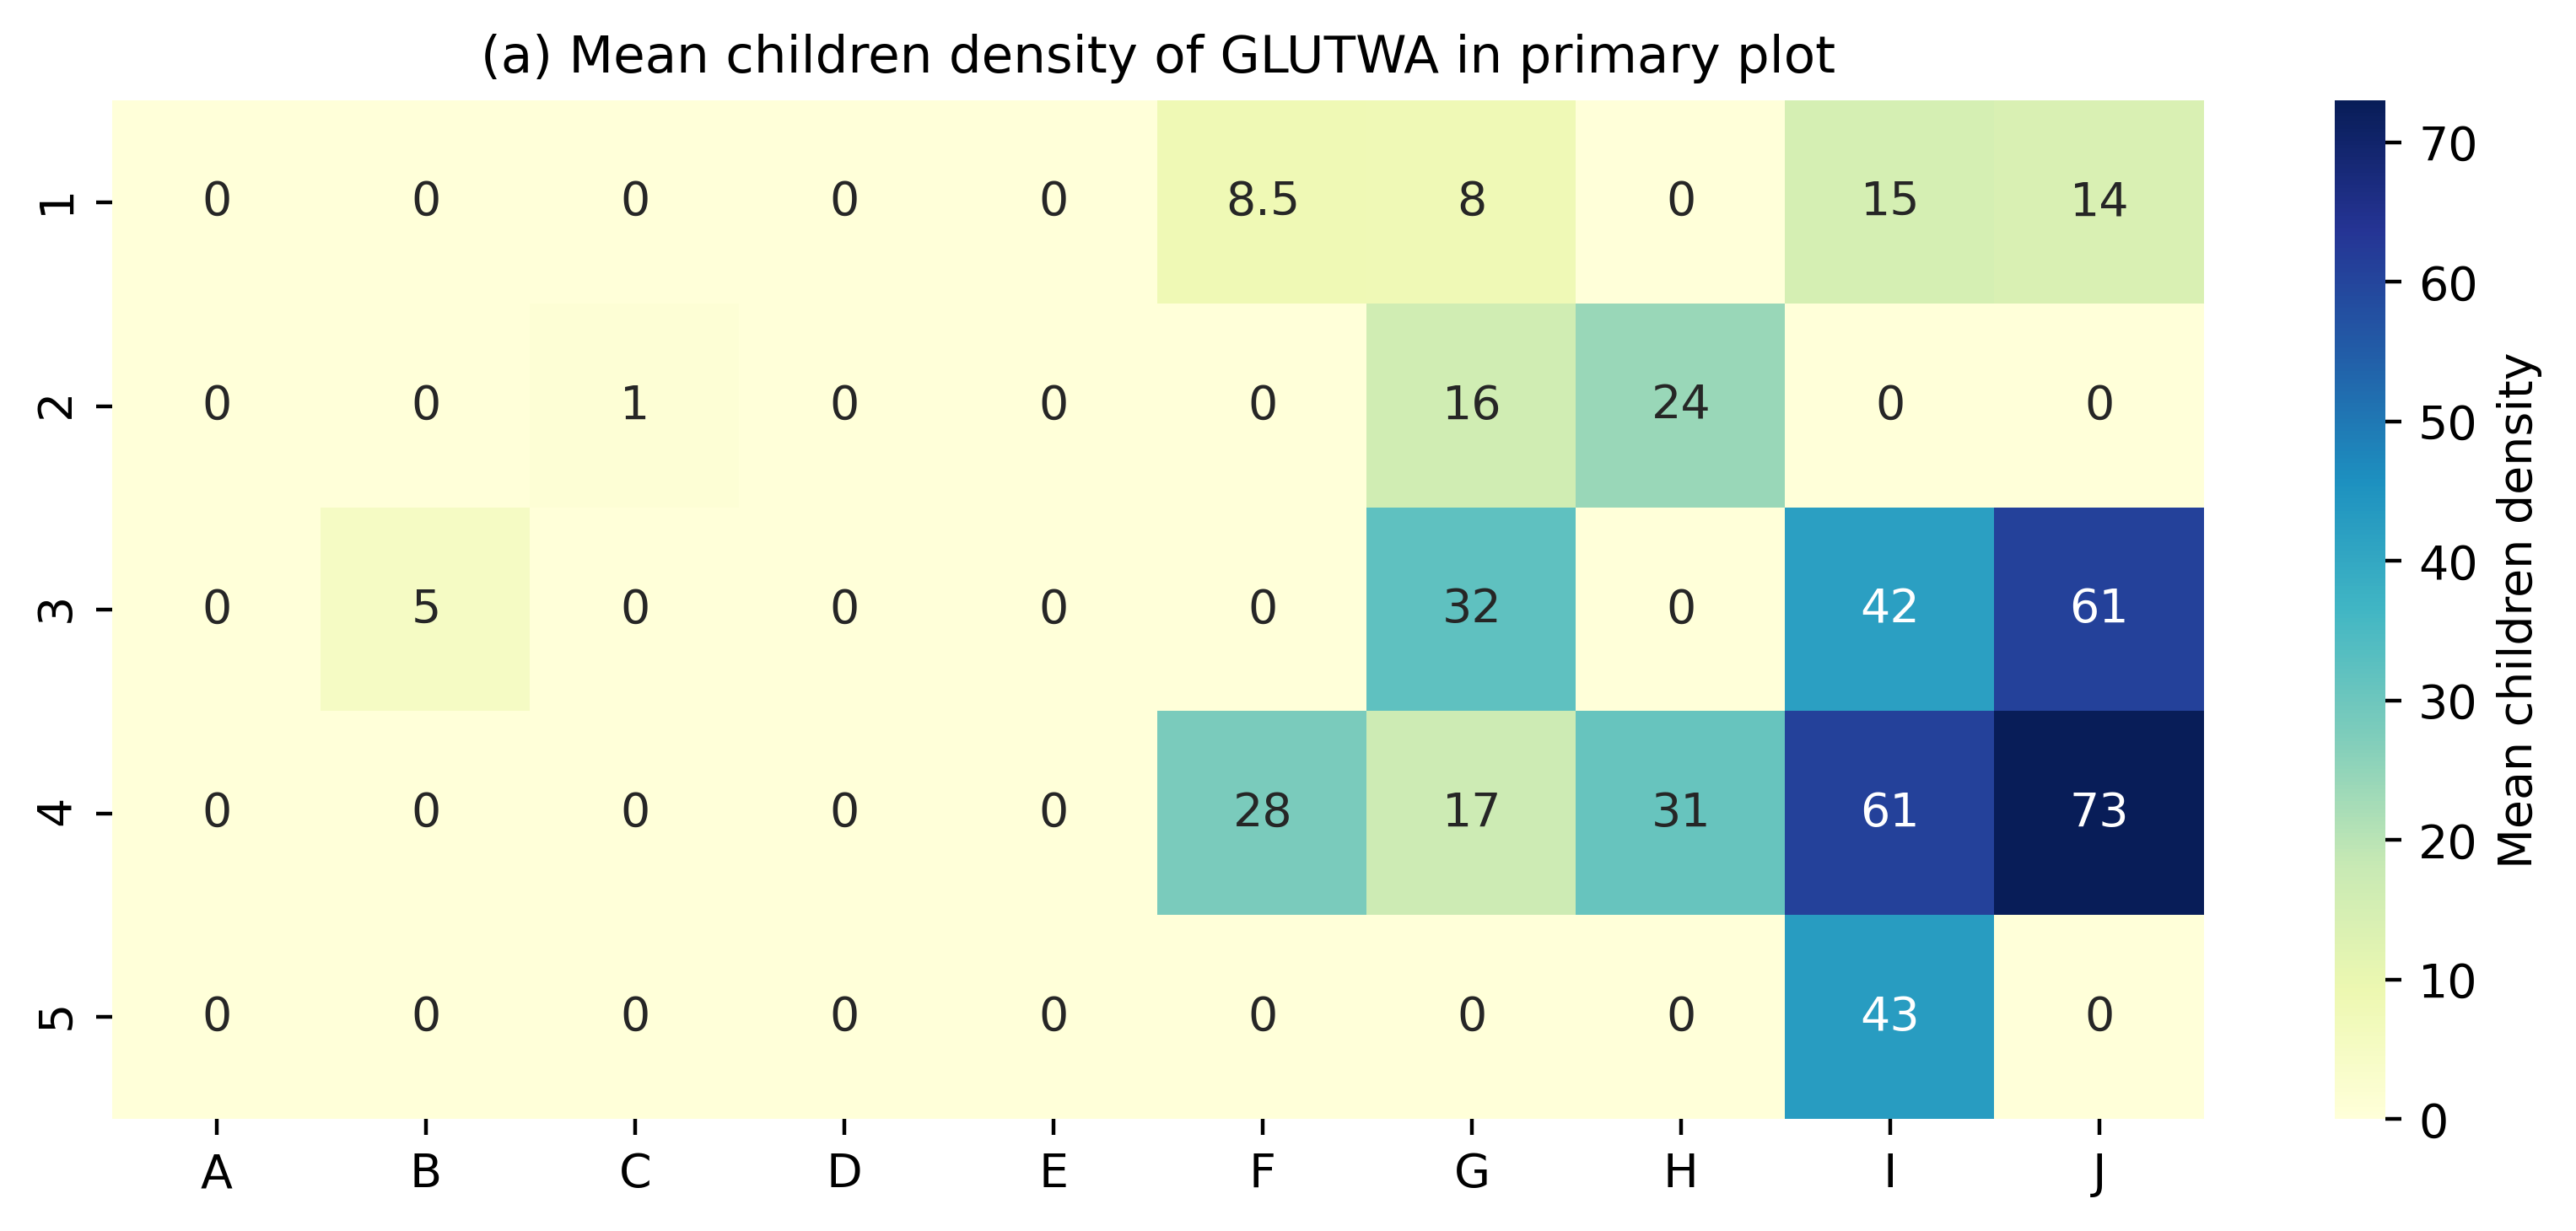

In [15]:
plot_heatmap(primary, 'GLUTWA', 'c20', "(a) Mean children density of GLUTWA in primary plot")

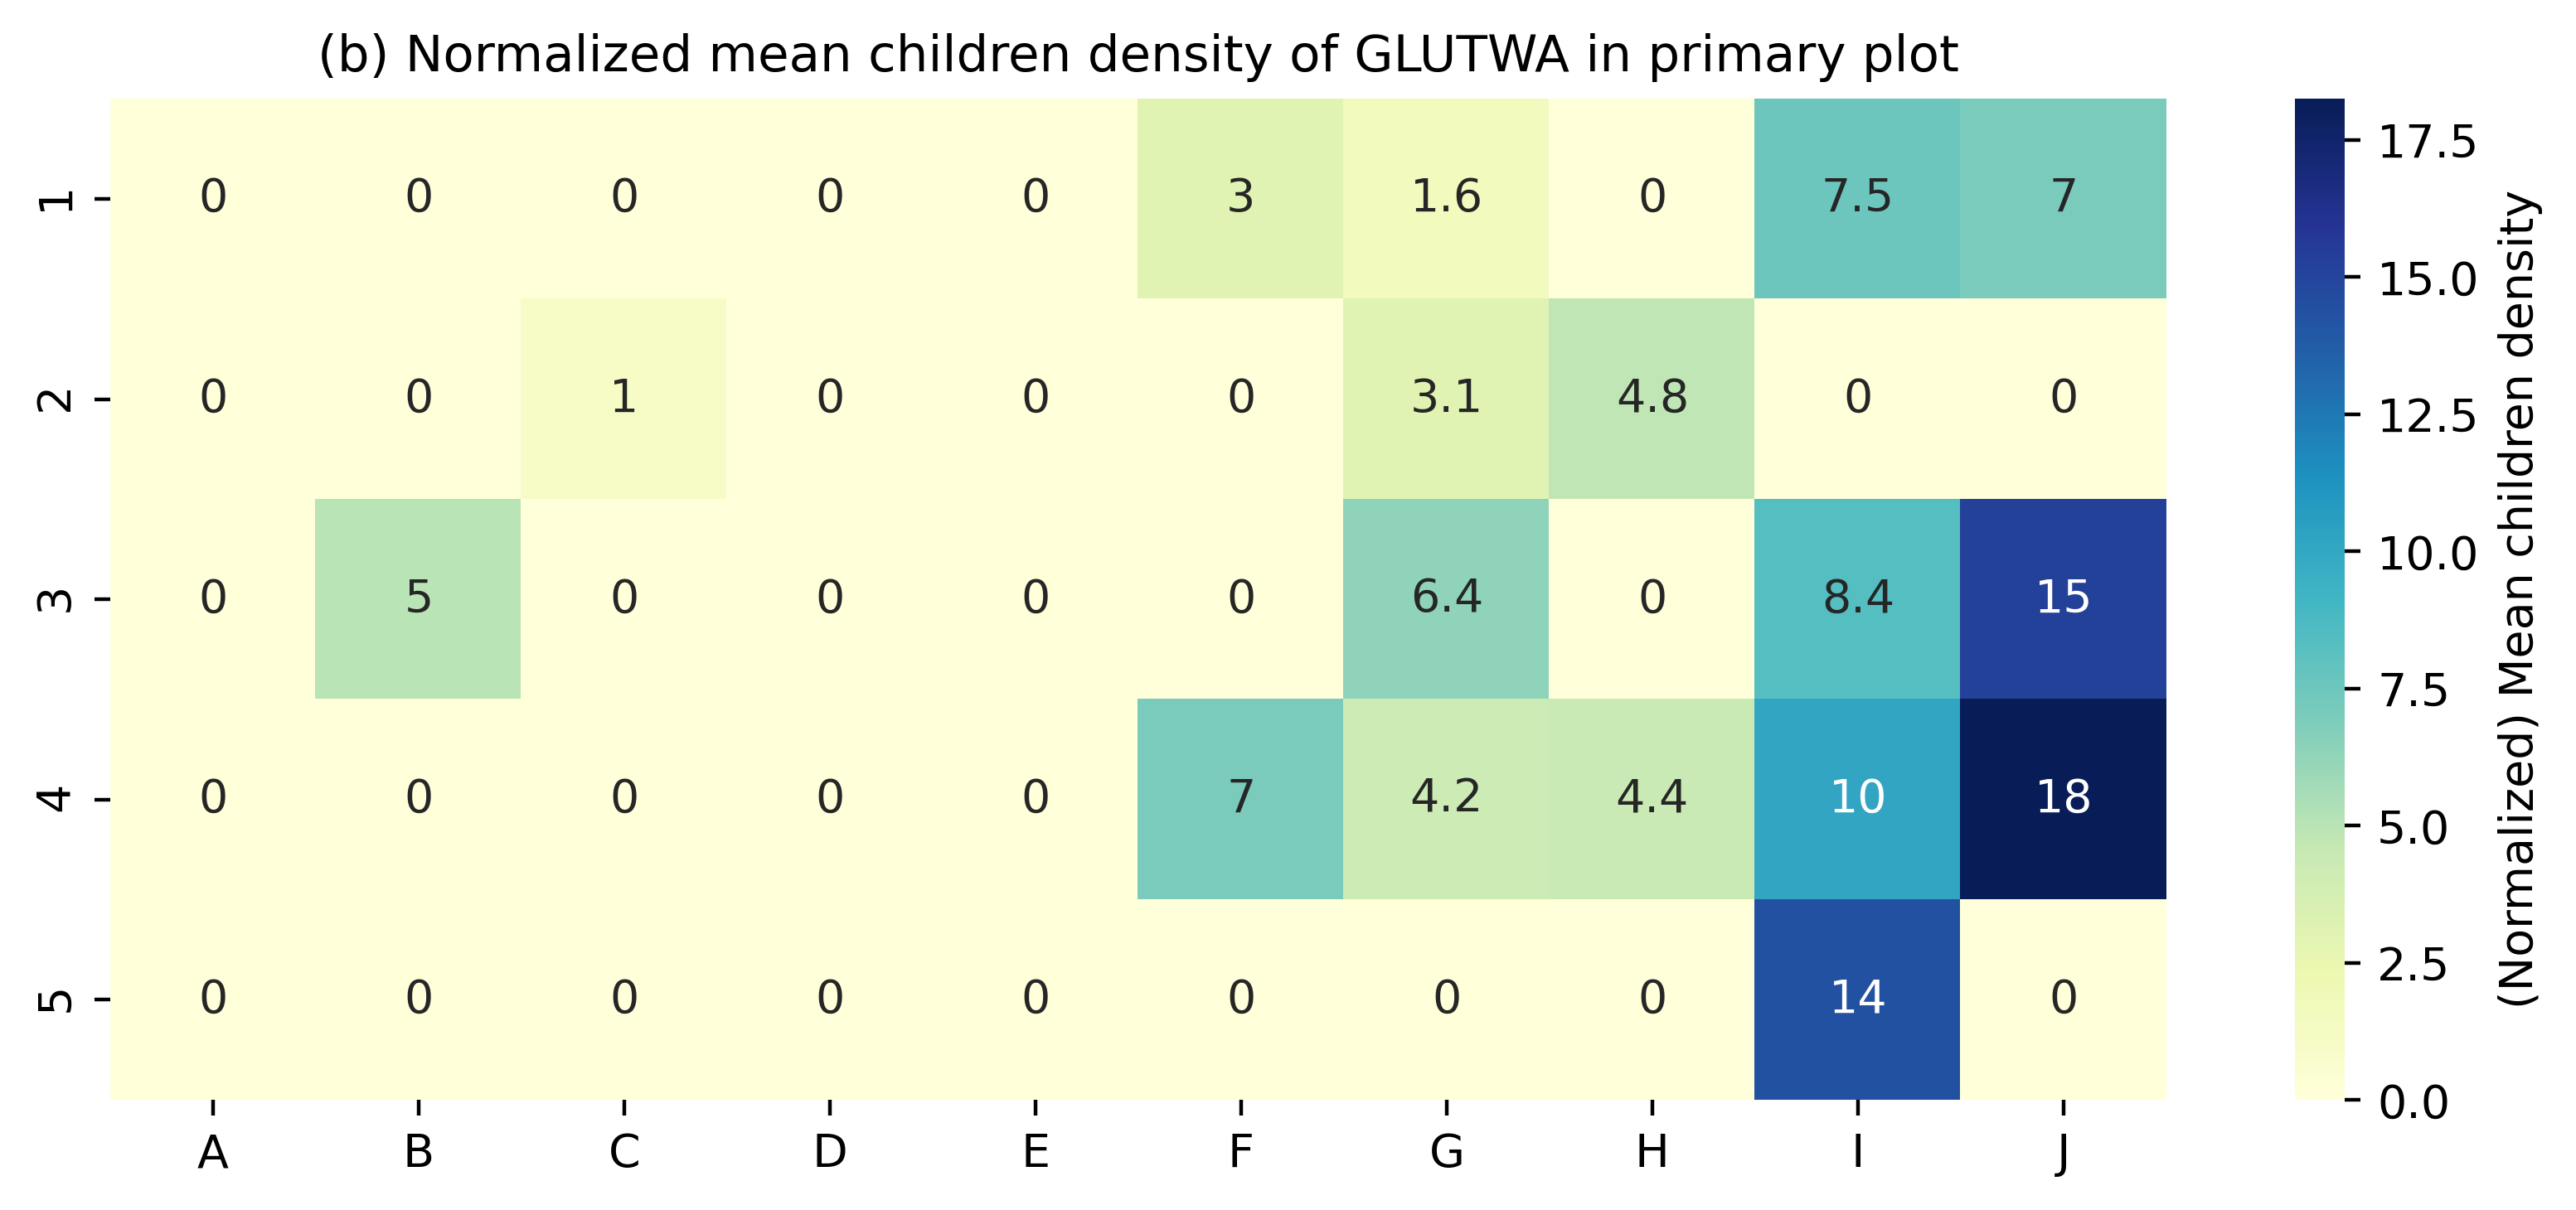

In [16]:
plot_heatmap(primary, 'GLUTWA', 'n20', "(b) Normalized mean children density of GLUTWA in primary plot")

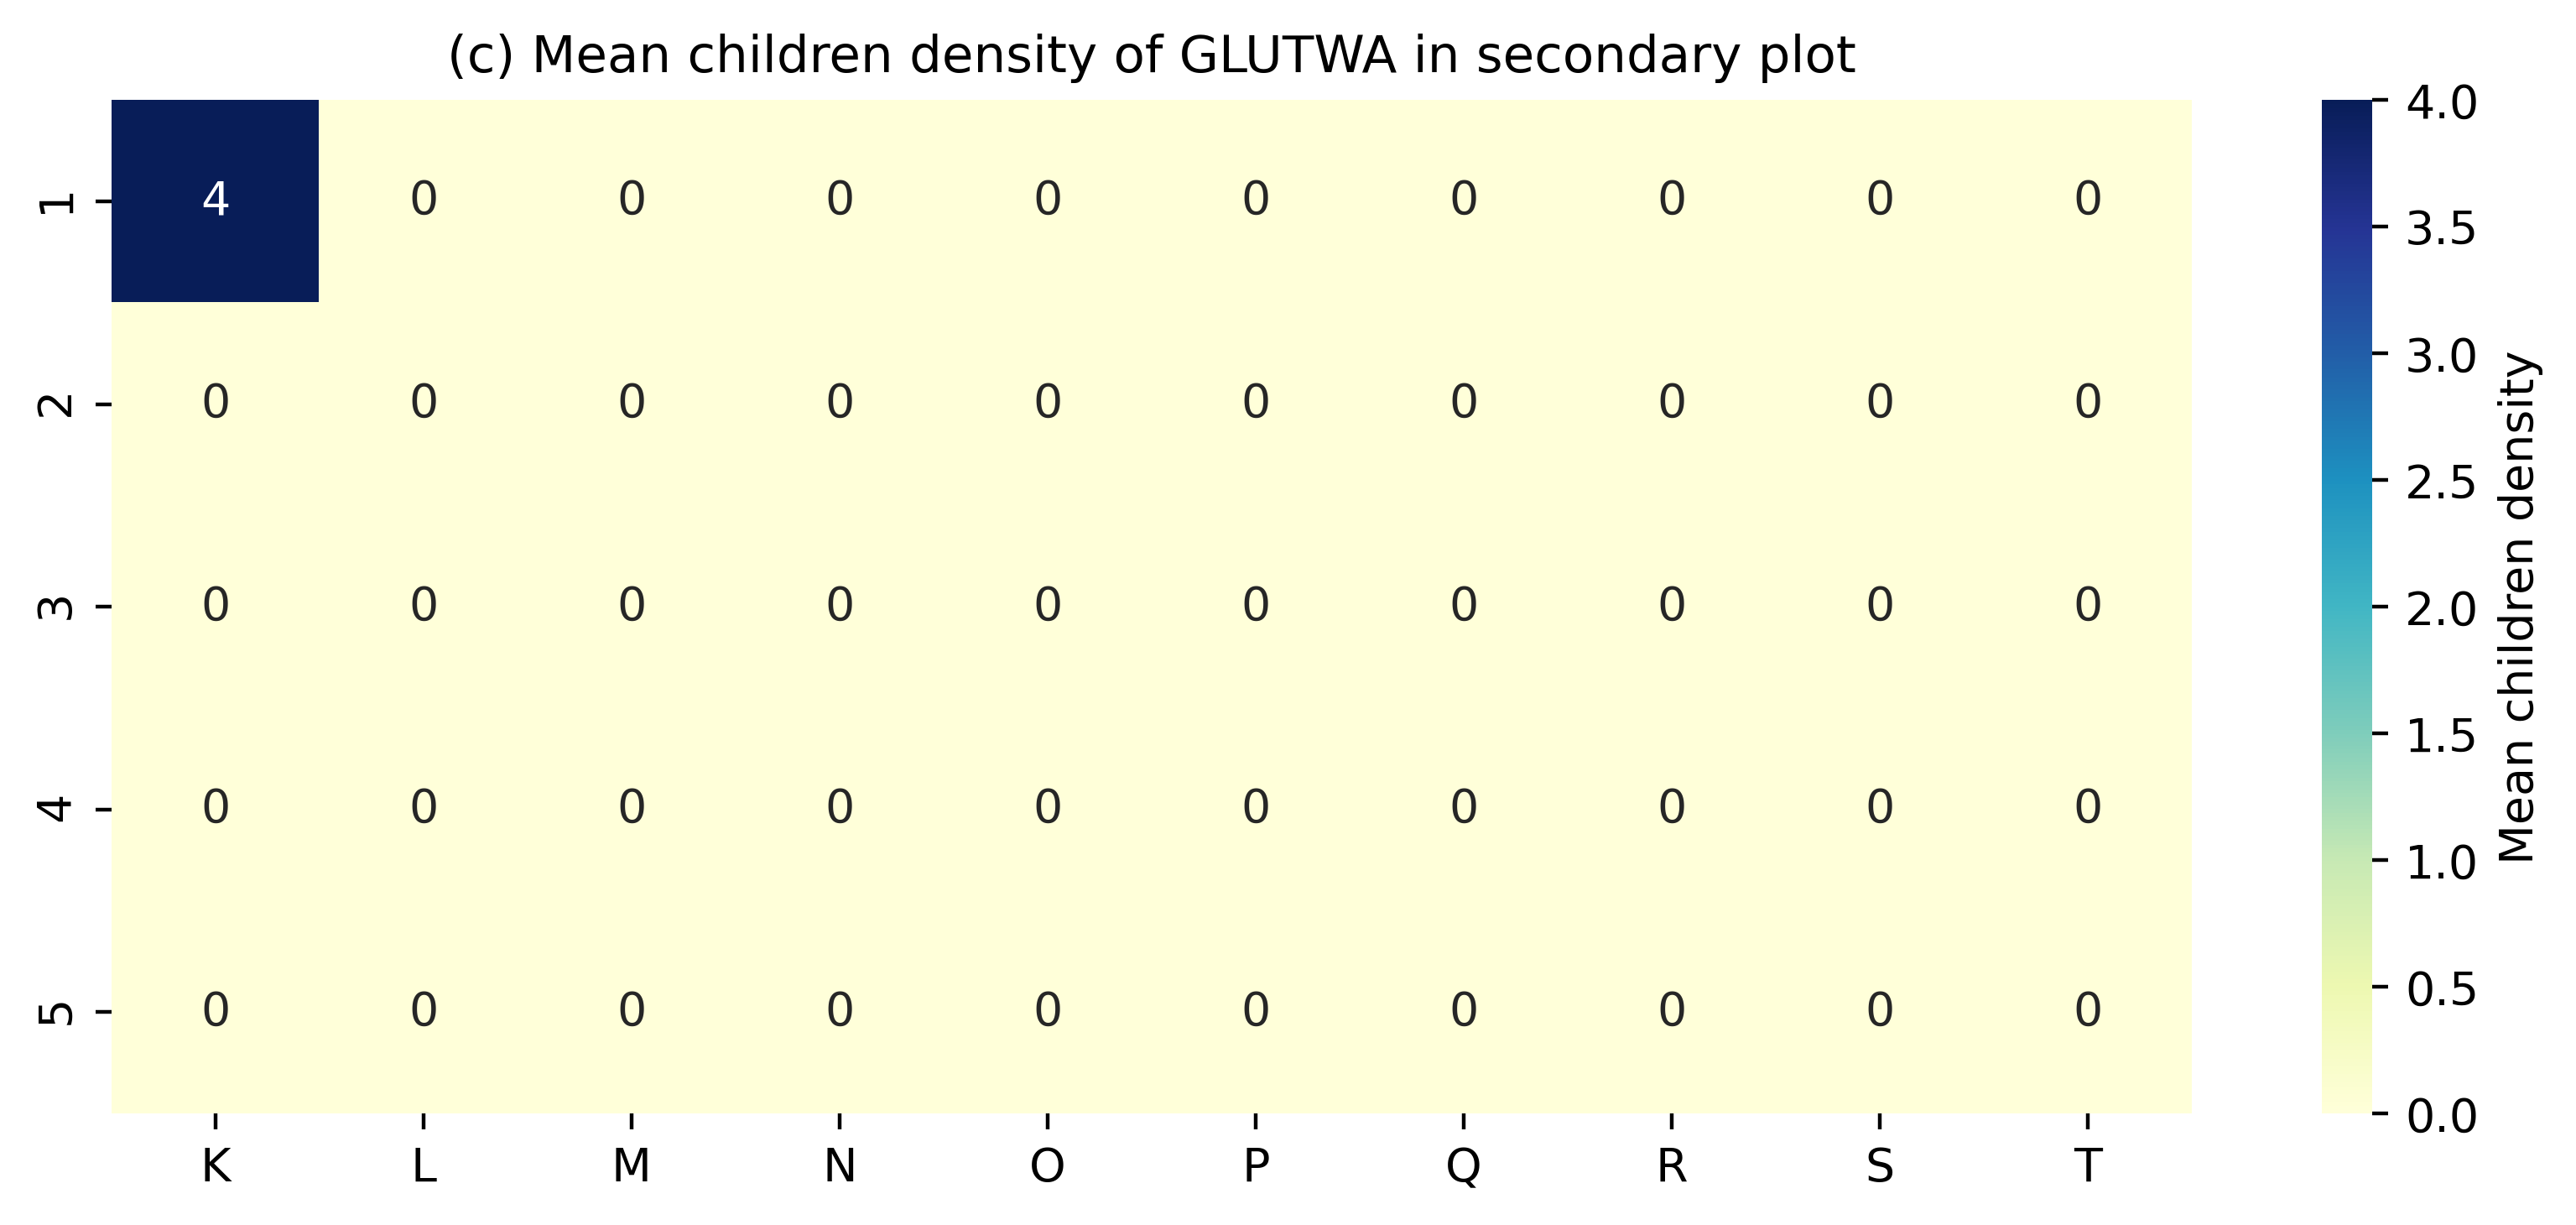

In [17]:
plot_heatmap(secondary, 'GLUTWA', 'c20', "(c) Mean children density of GLUTWA in secondary plot")

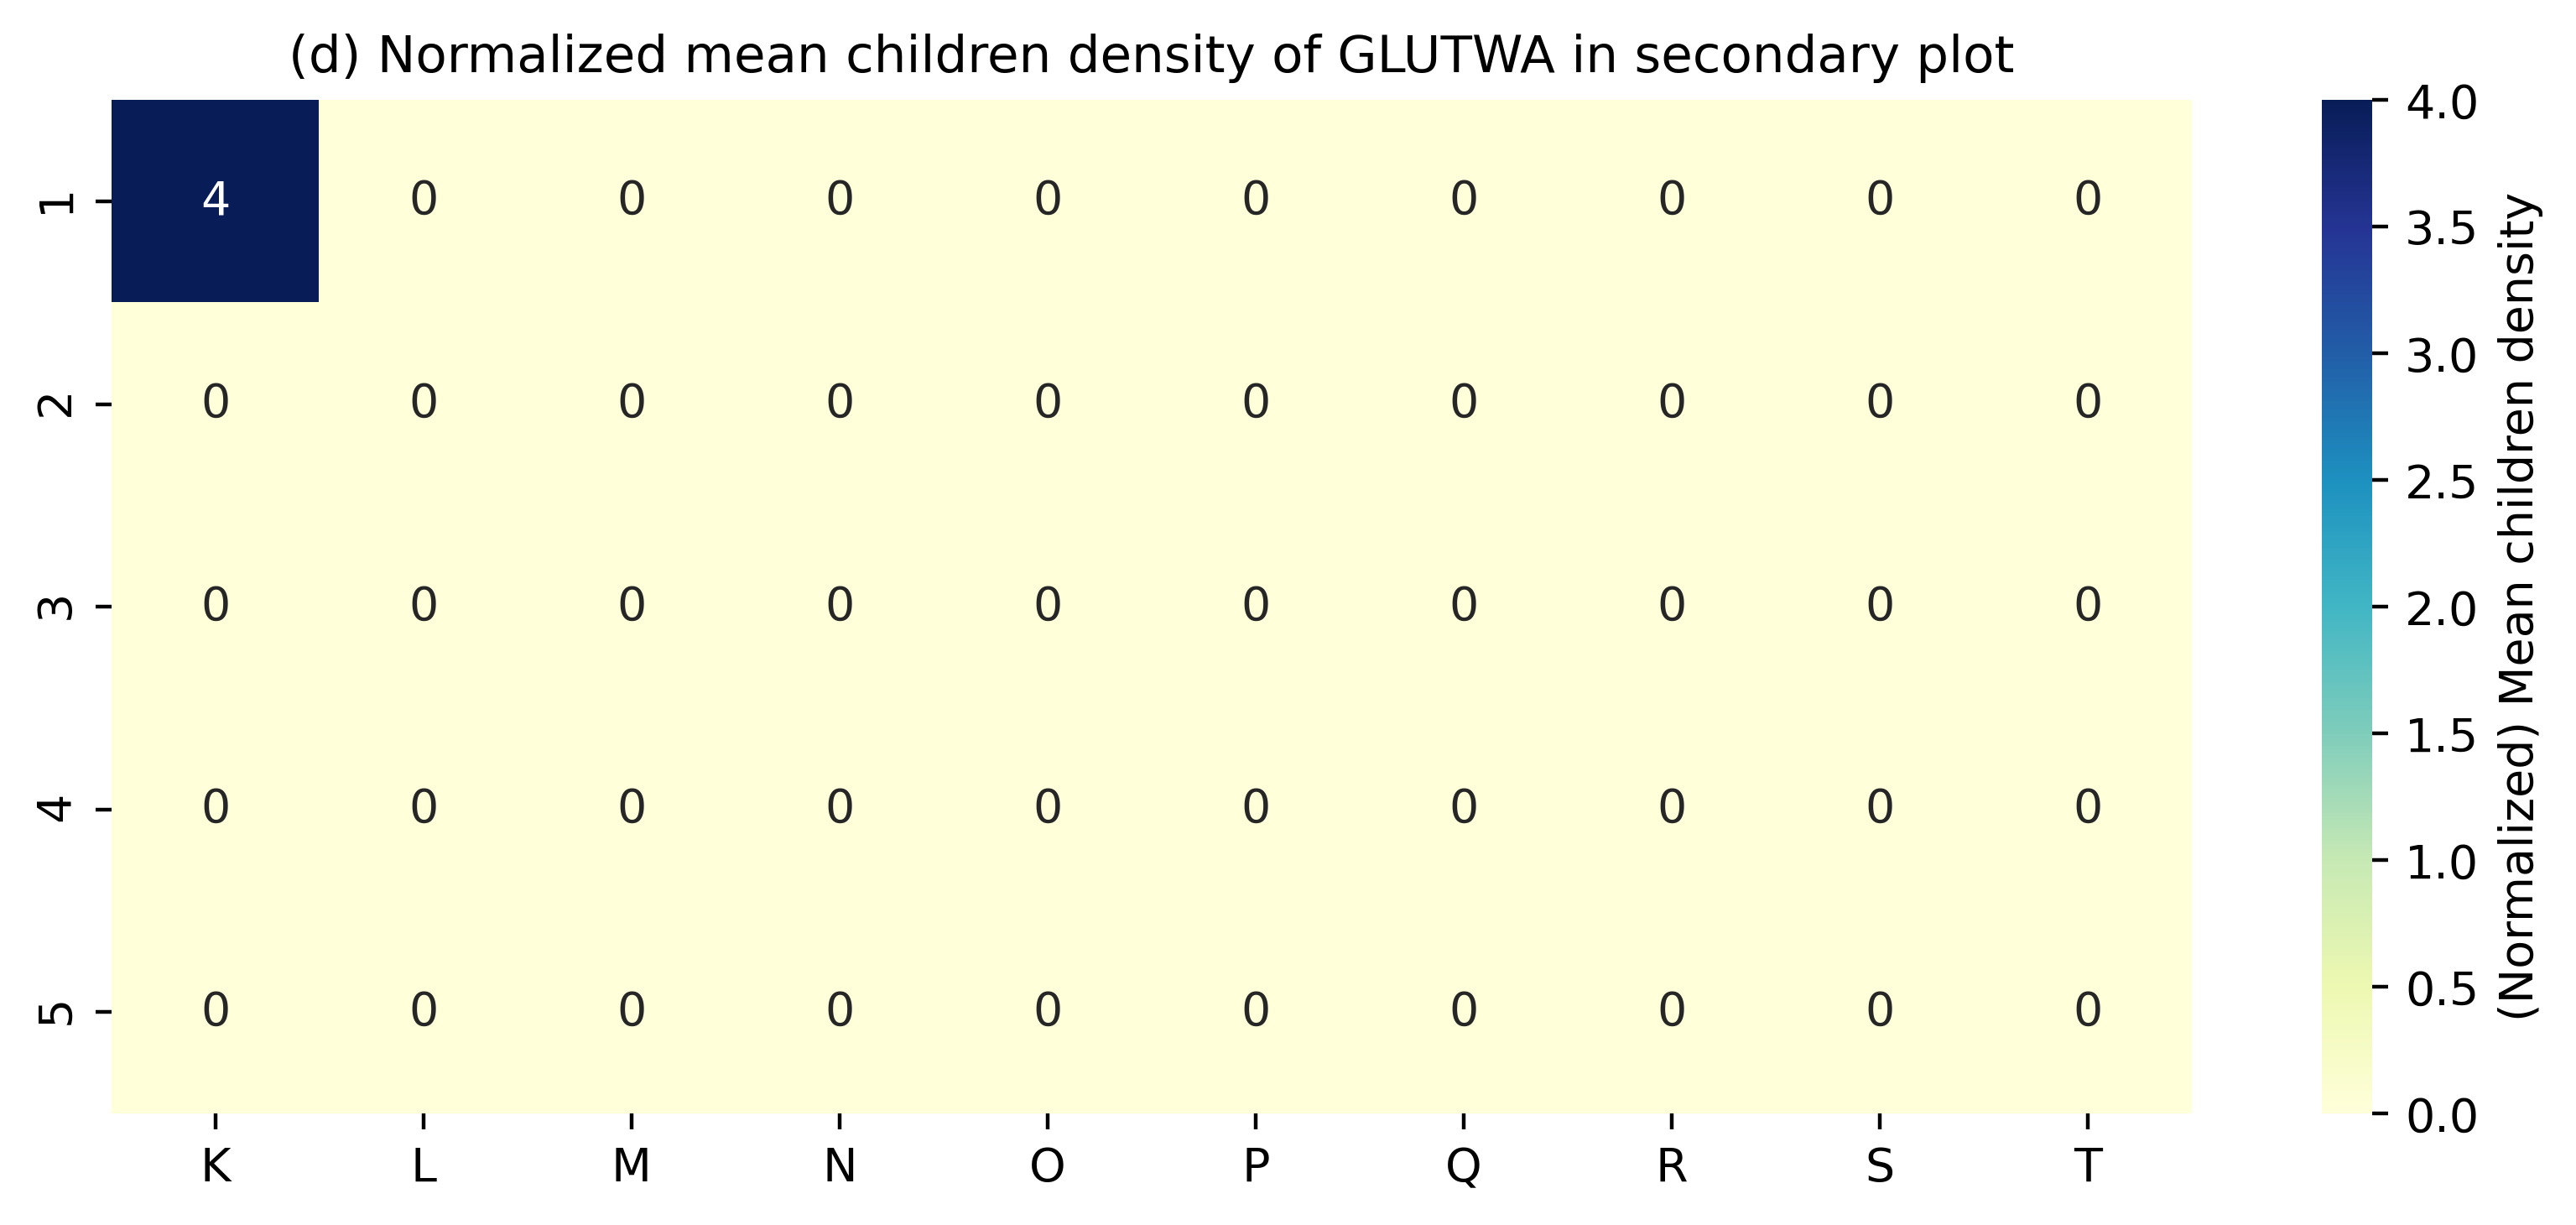

In [18]:
plot_heatmap(secondary, 'GLUTWA', 'n20', "(d) Normalized mean children density of GLUTWA in secondary plot")

## HOPEME

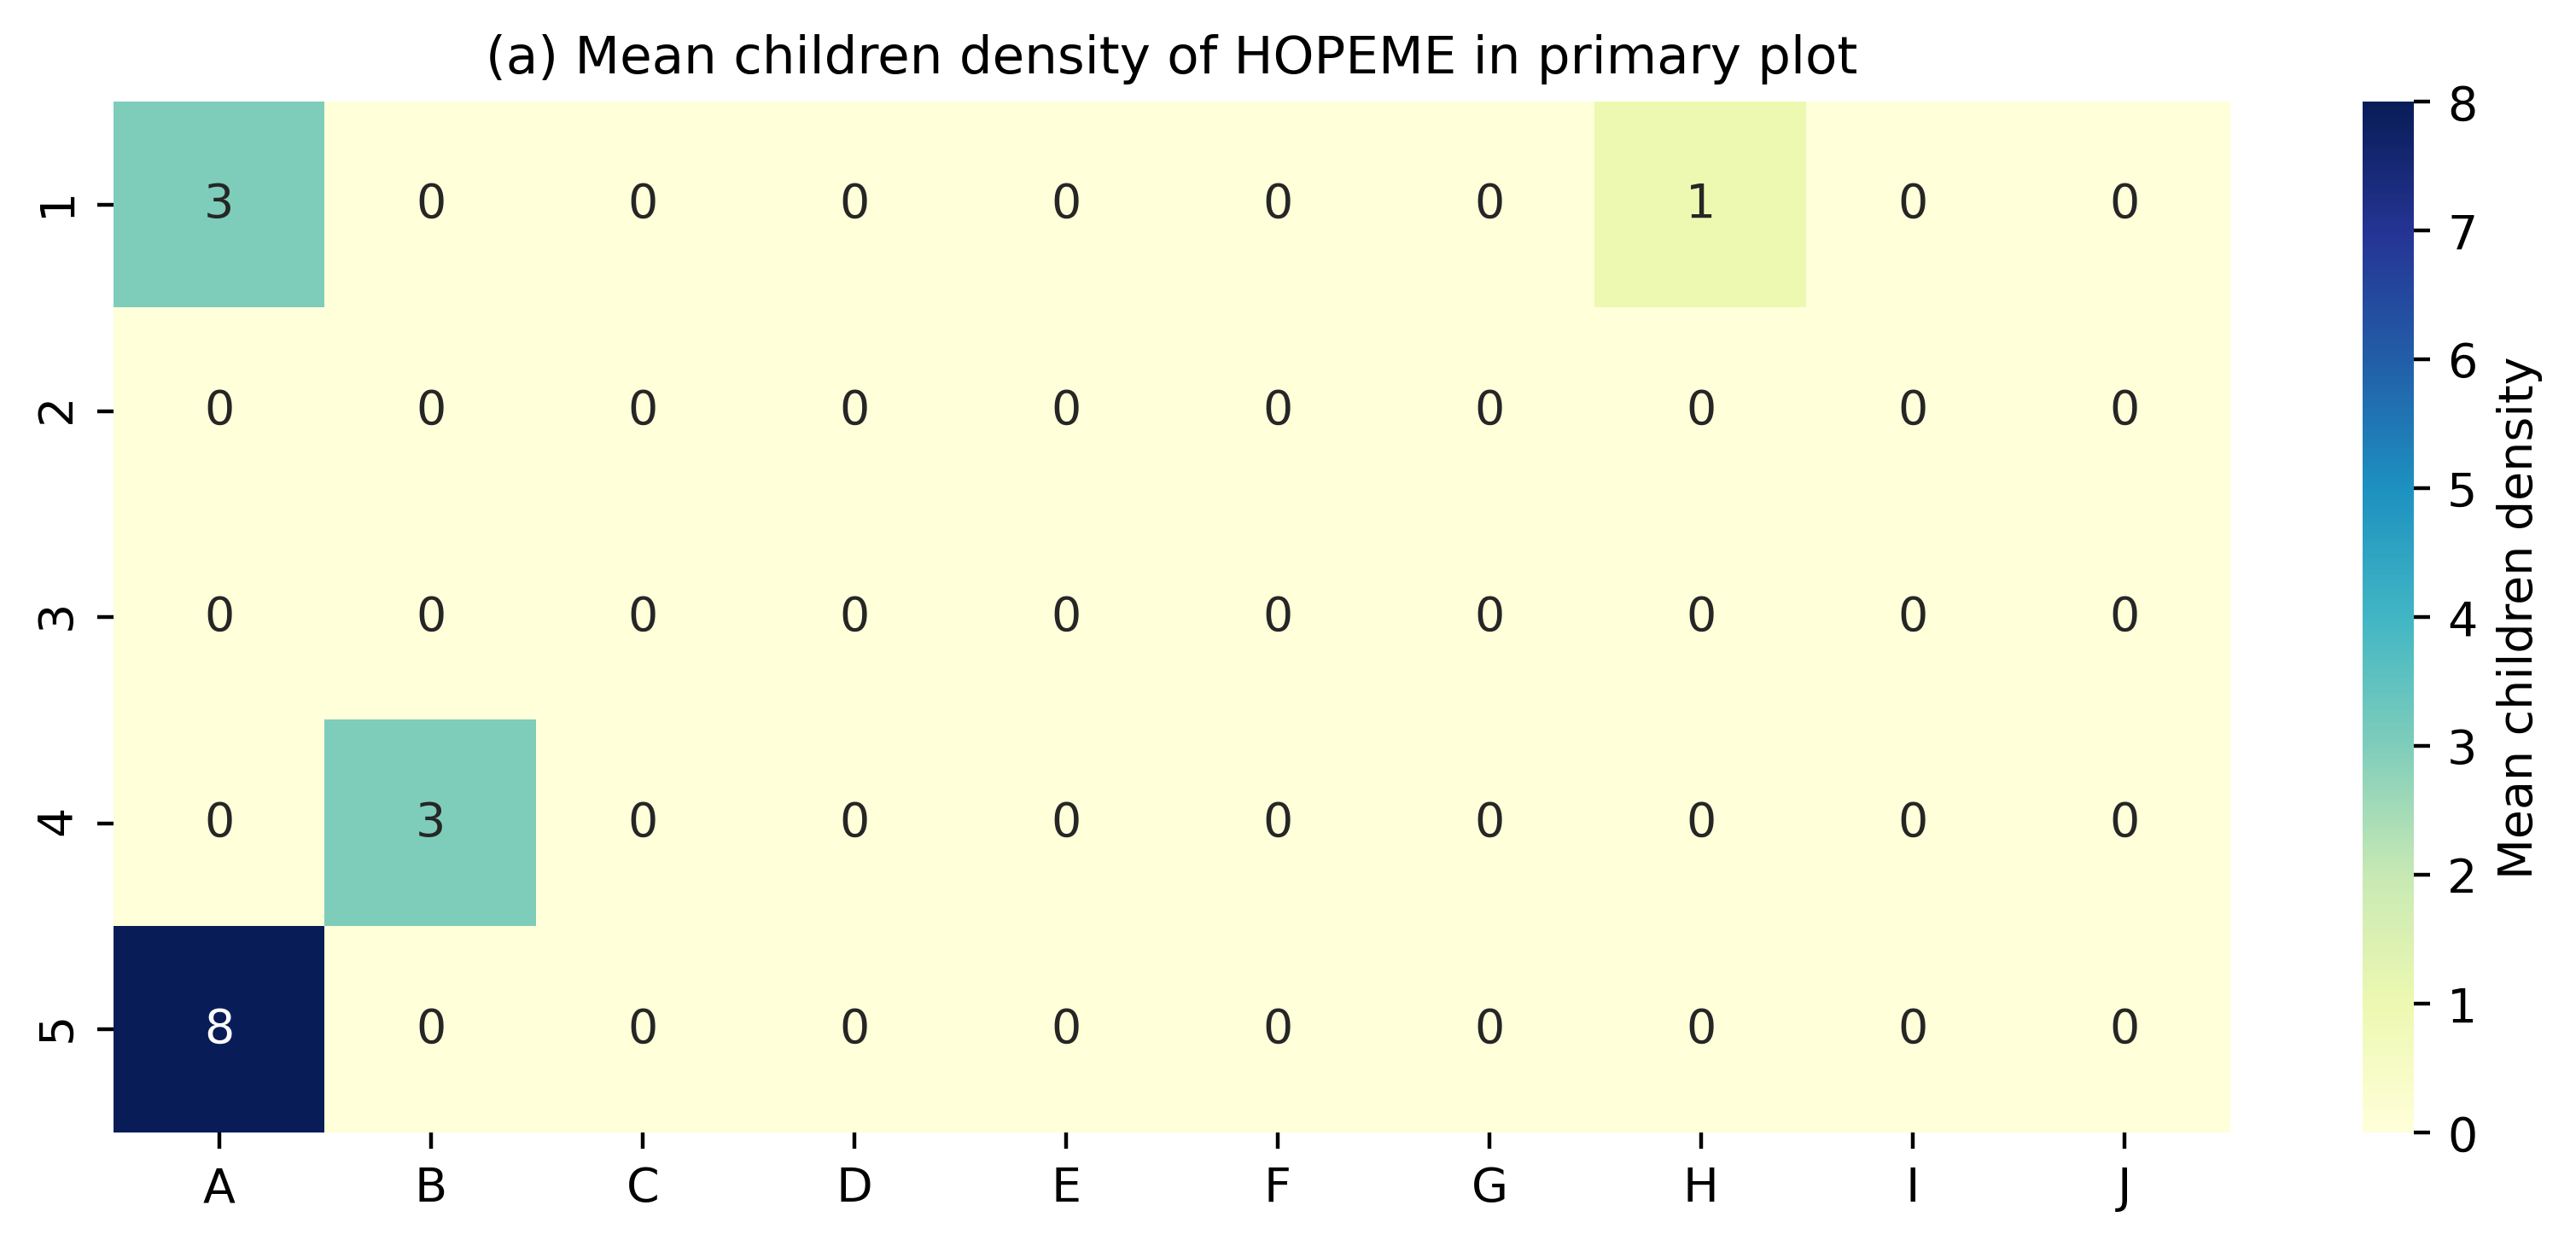

In [19]:
plot_heatmap(primary, 'HOPEME', 'c20', "(a) Mean children density of HOPEME in primary plot")

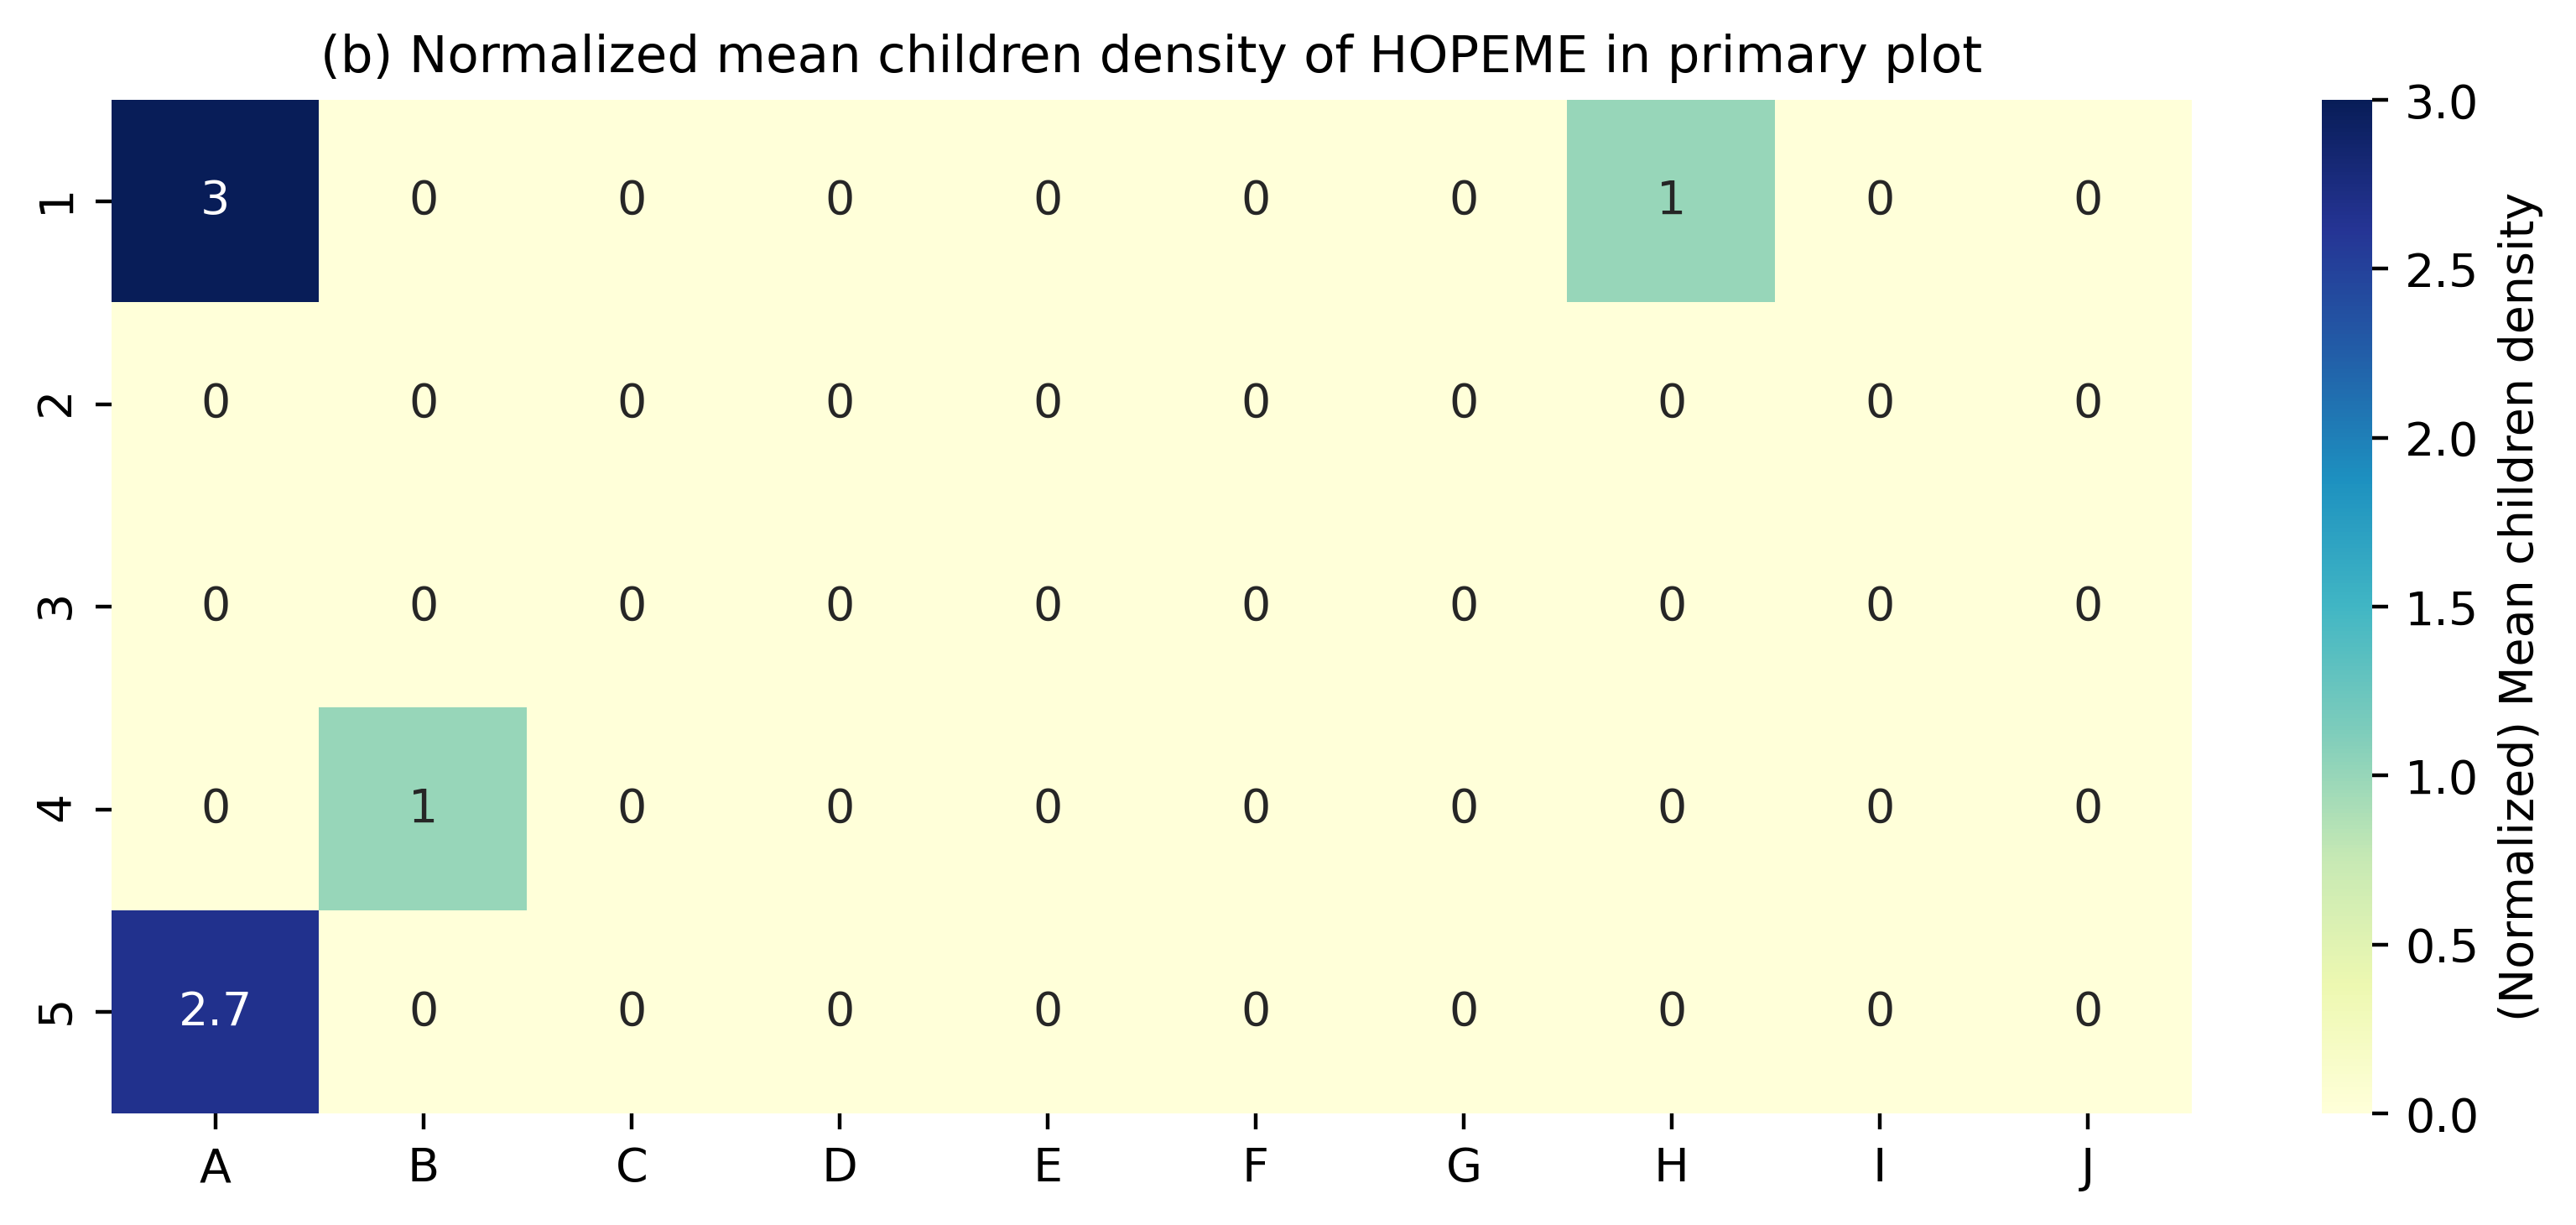

In [20]:
plot_heatmap(primary, 'HOPEME', 'n20', "(b) Normalized mean children density of HOPEME in primary plot")

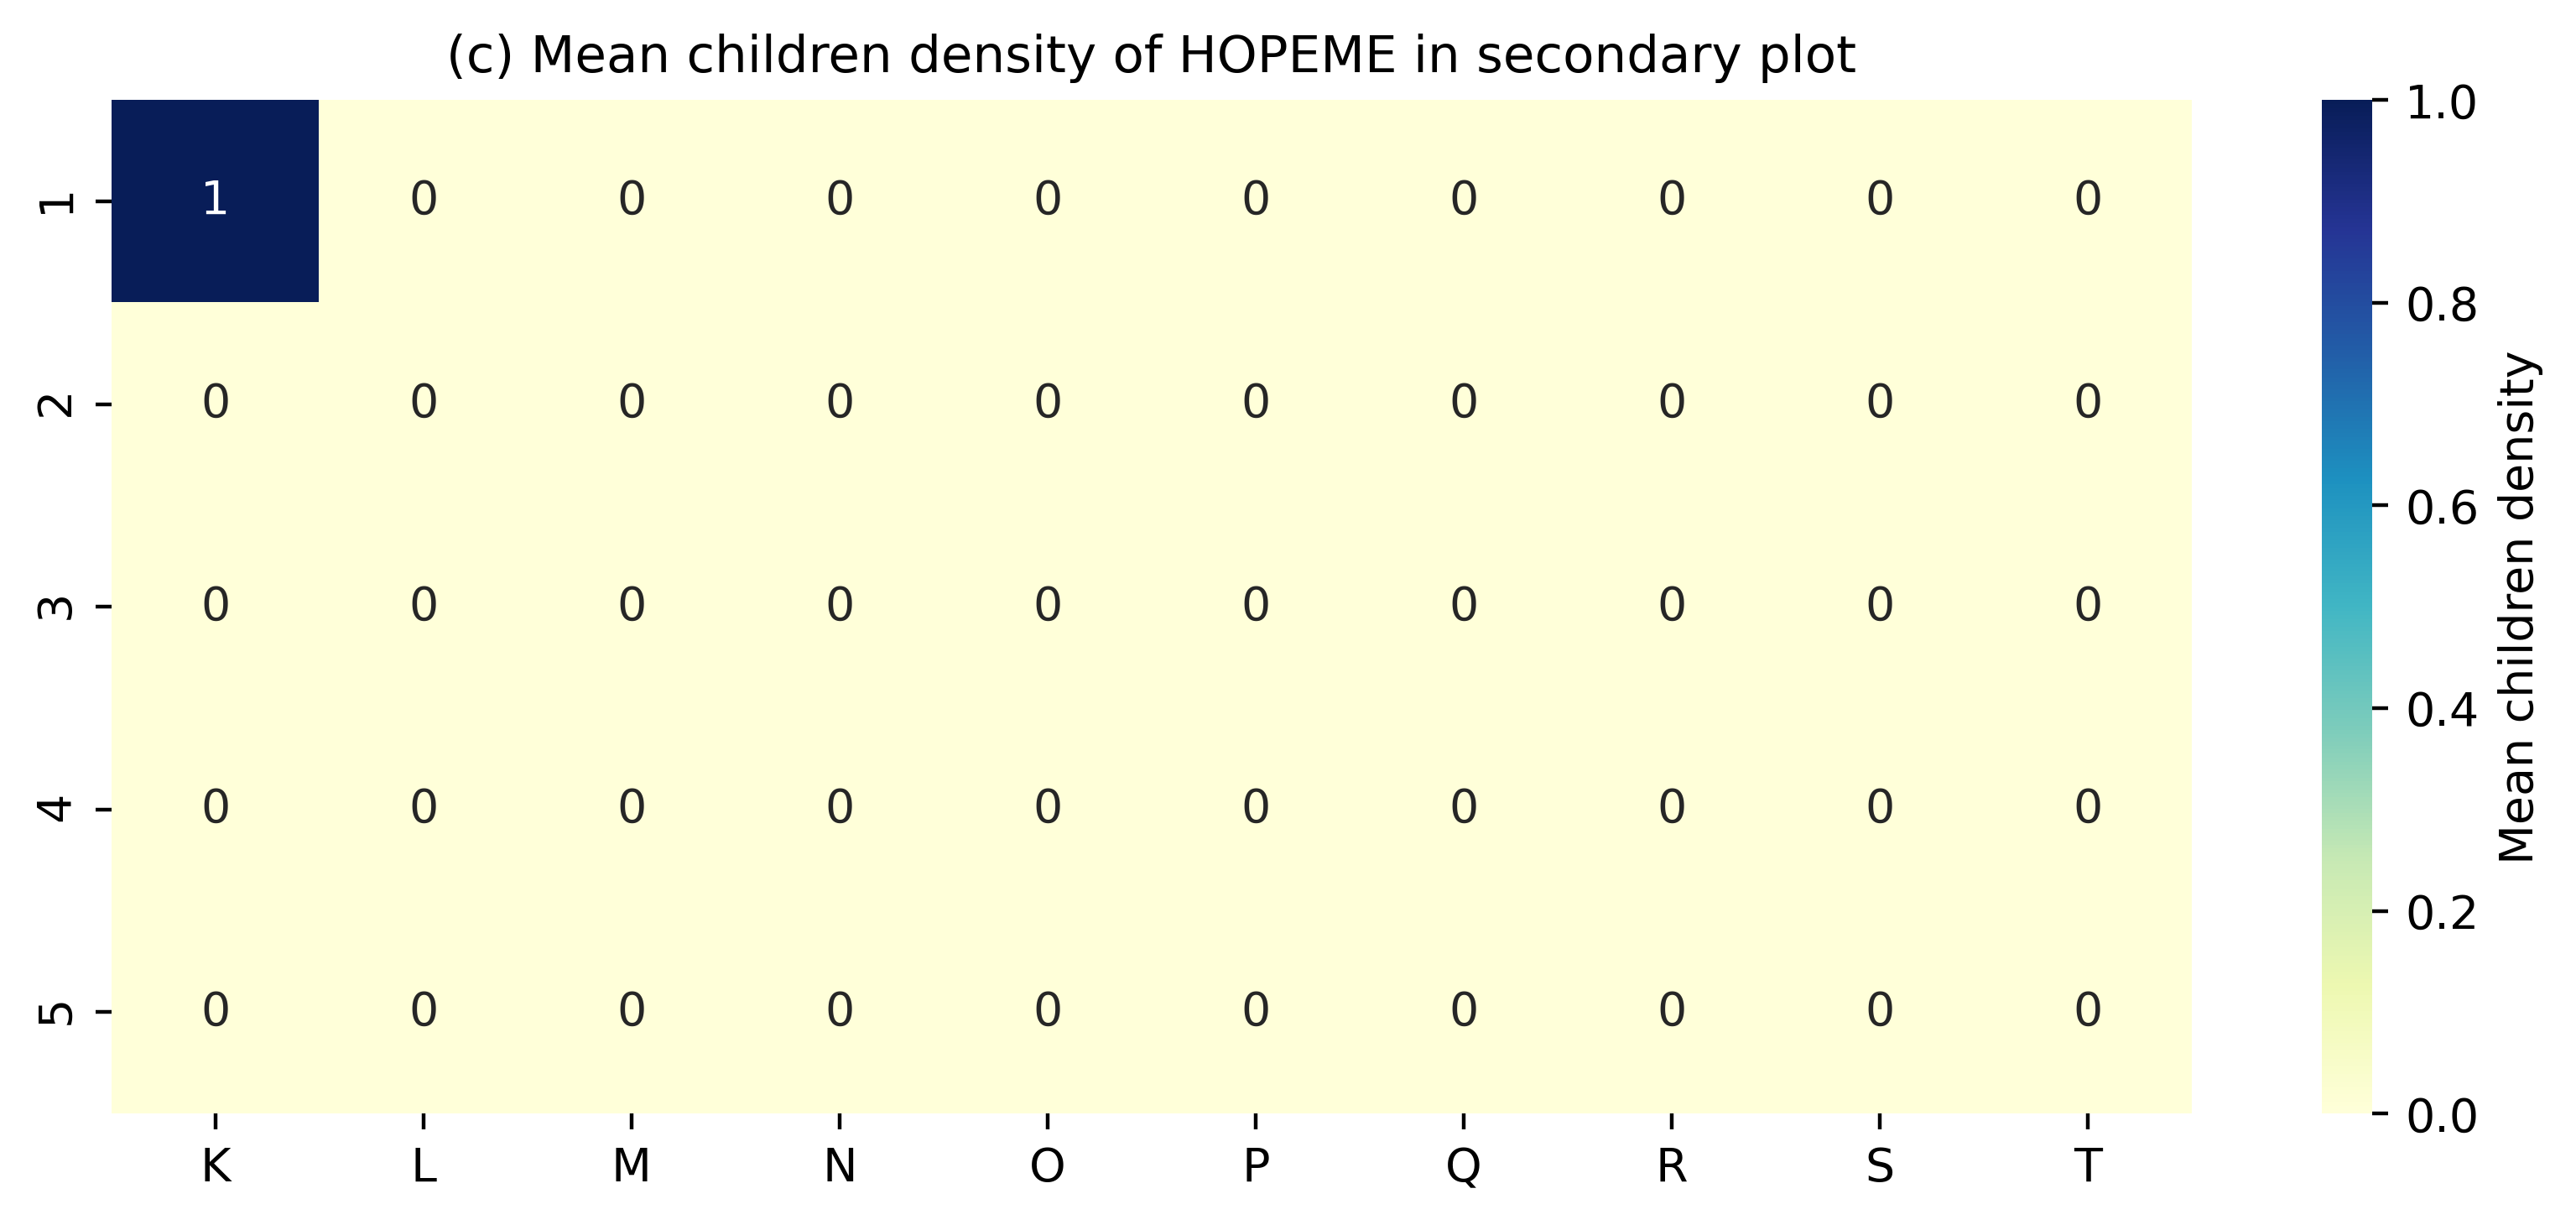

In [21]:
plot_heatmap(secondary, 'HOPEME', 'c20', "(c) Mean children density of HOPEME in secondary plot")

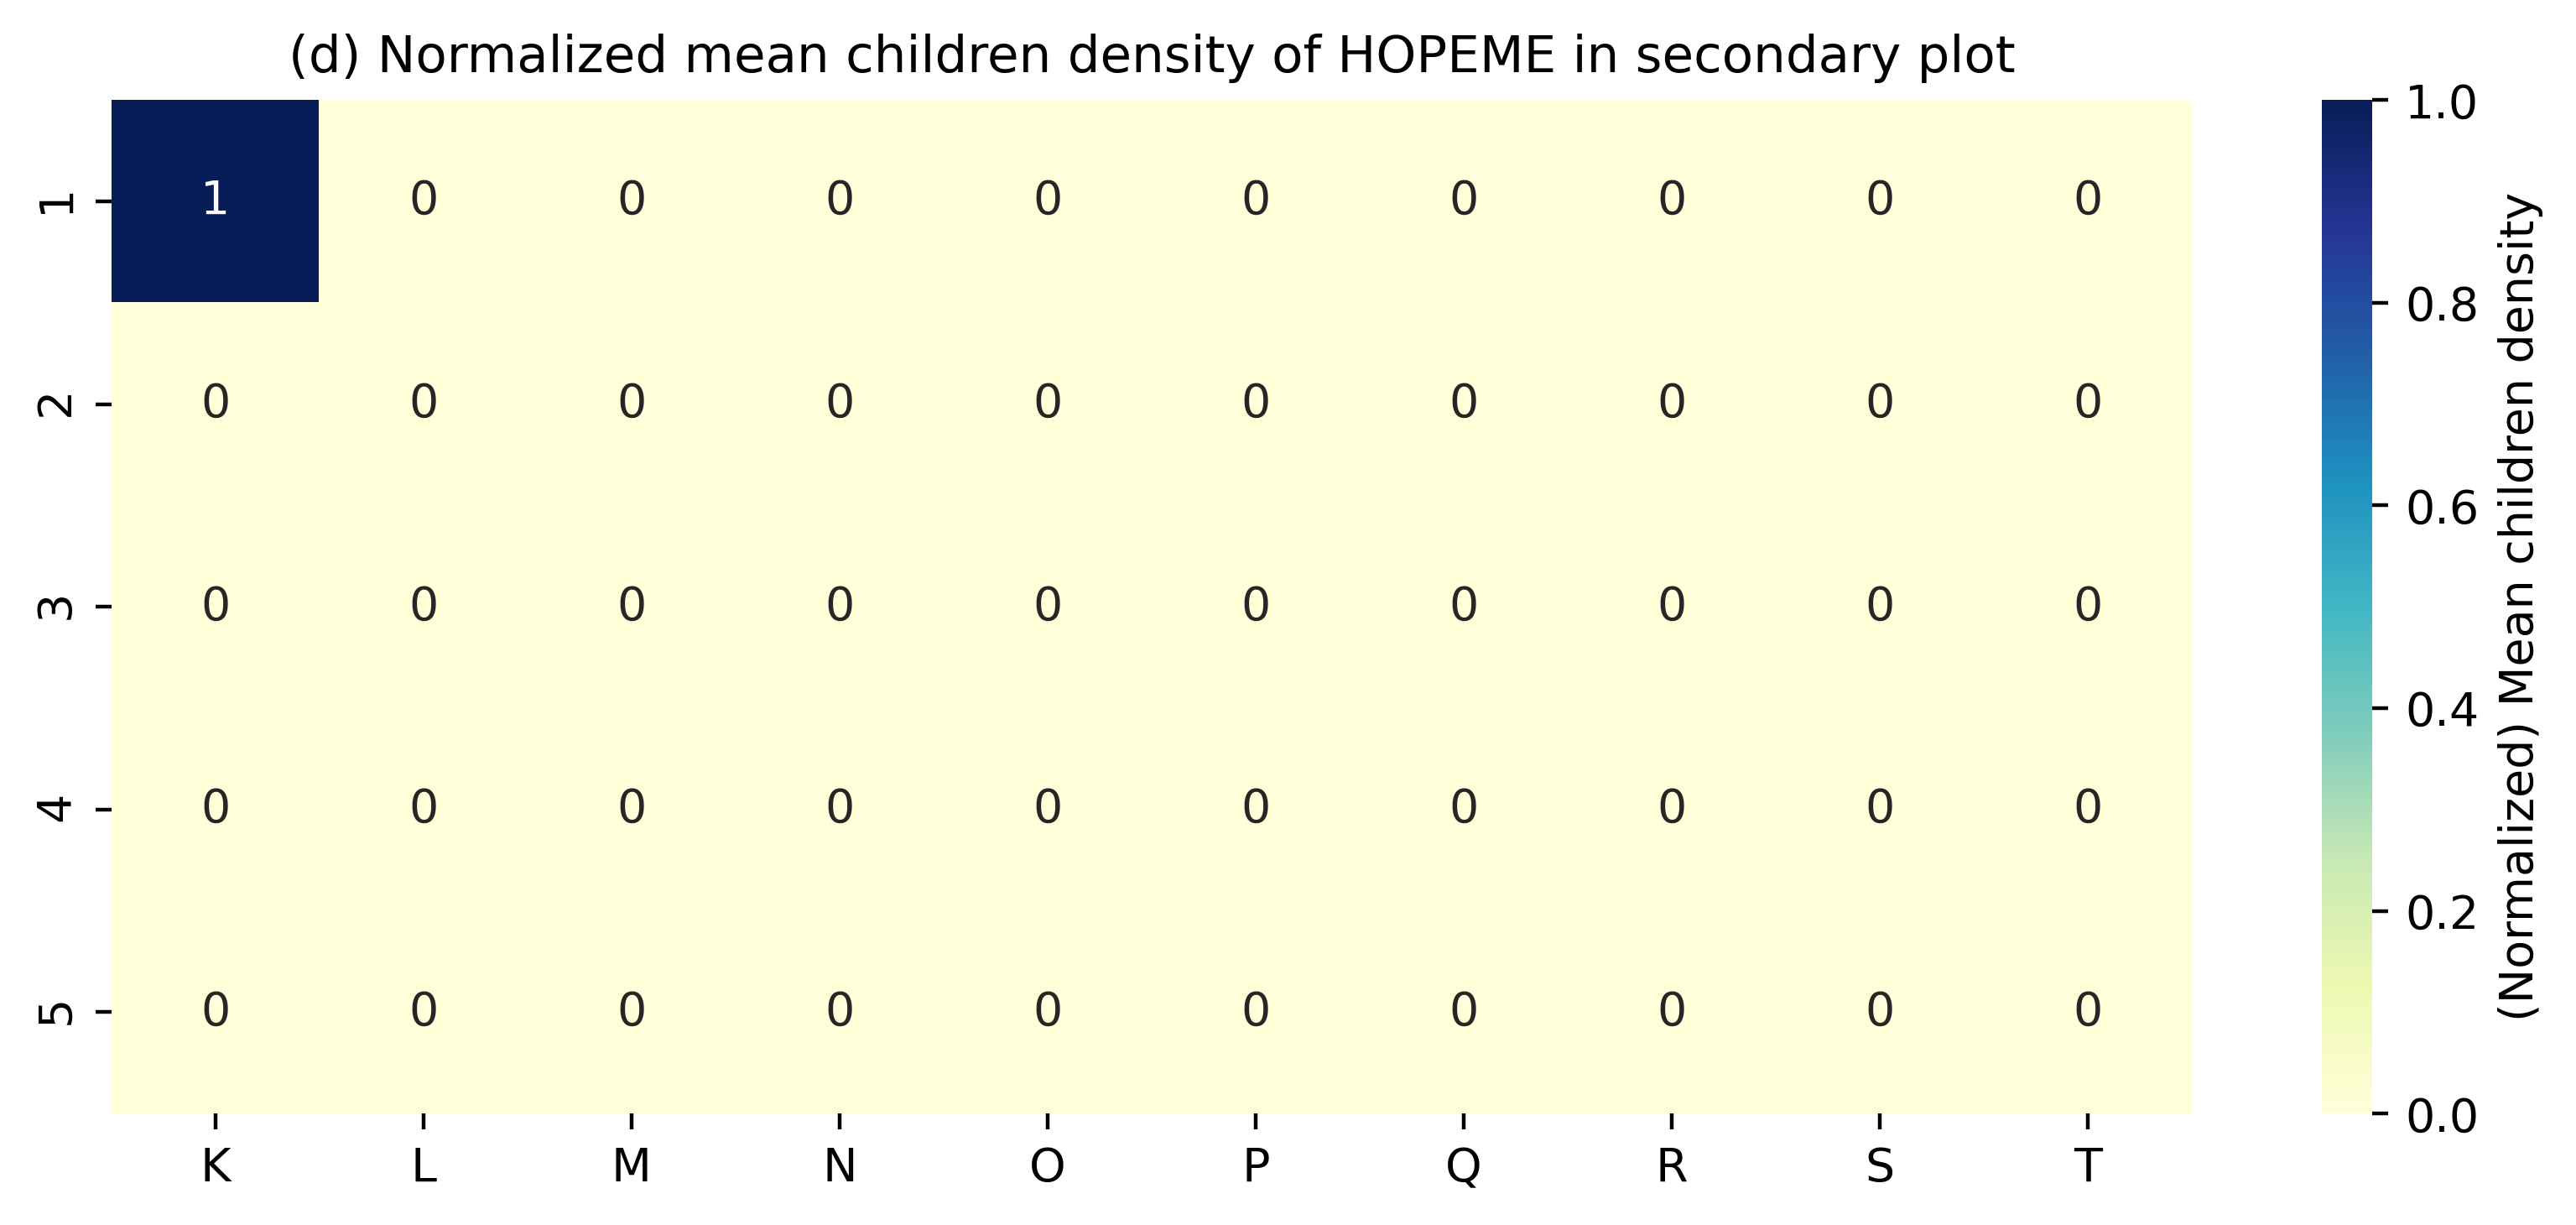

In [22]:
plot_heatmap(secondary, 'HOPEME', 'n20', "(d) Normalized mean children density of HOPEME in secondary plot")

## DIPTCA

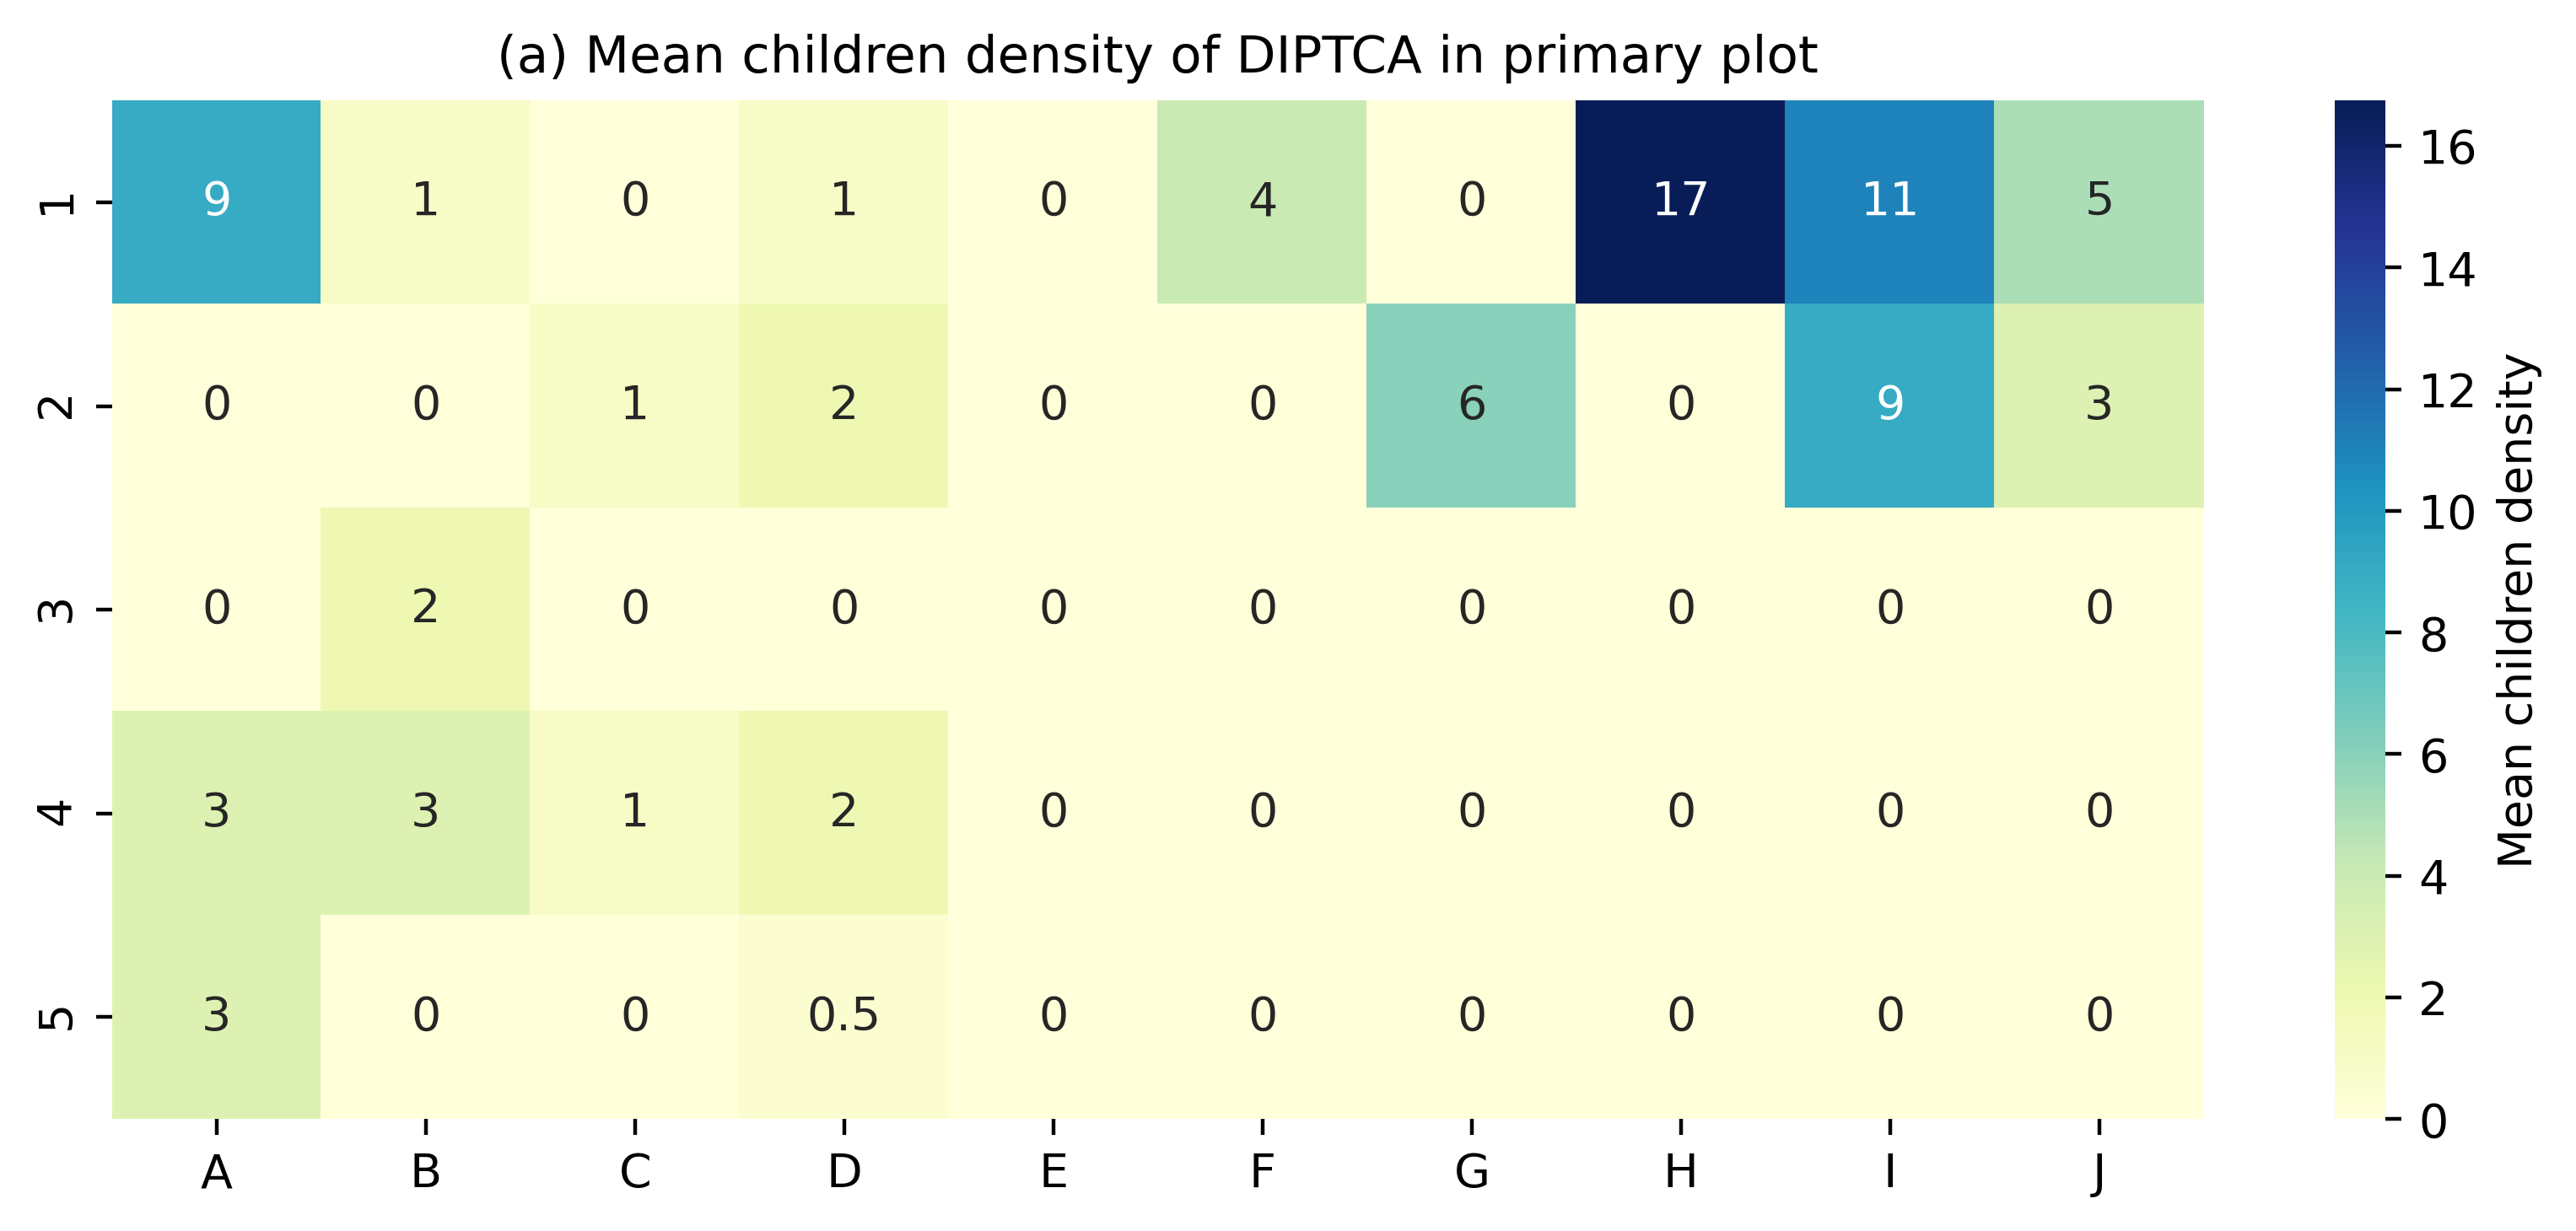

In [23]:
plot_heatmap(primary, 'DIPTCA', 'c20', "(a) Mean children density of DIPTCA in primary plot")

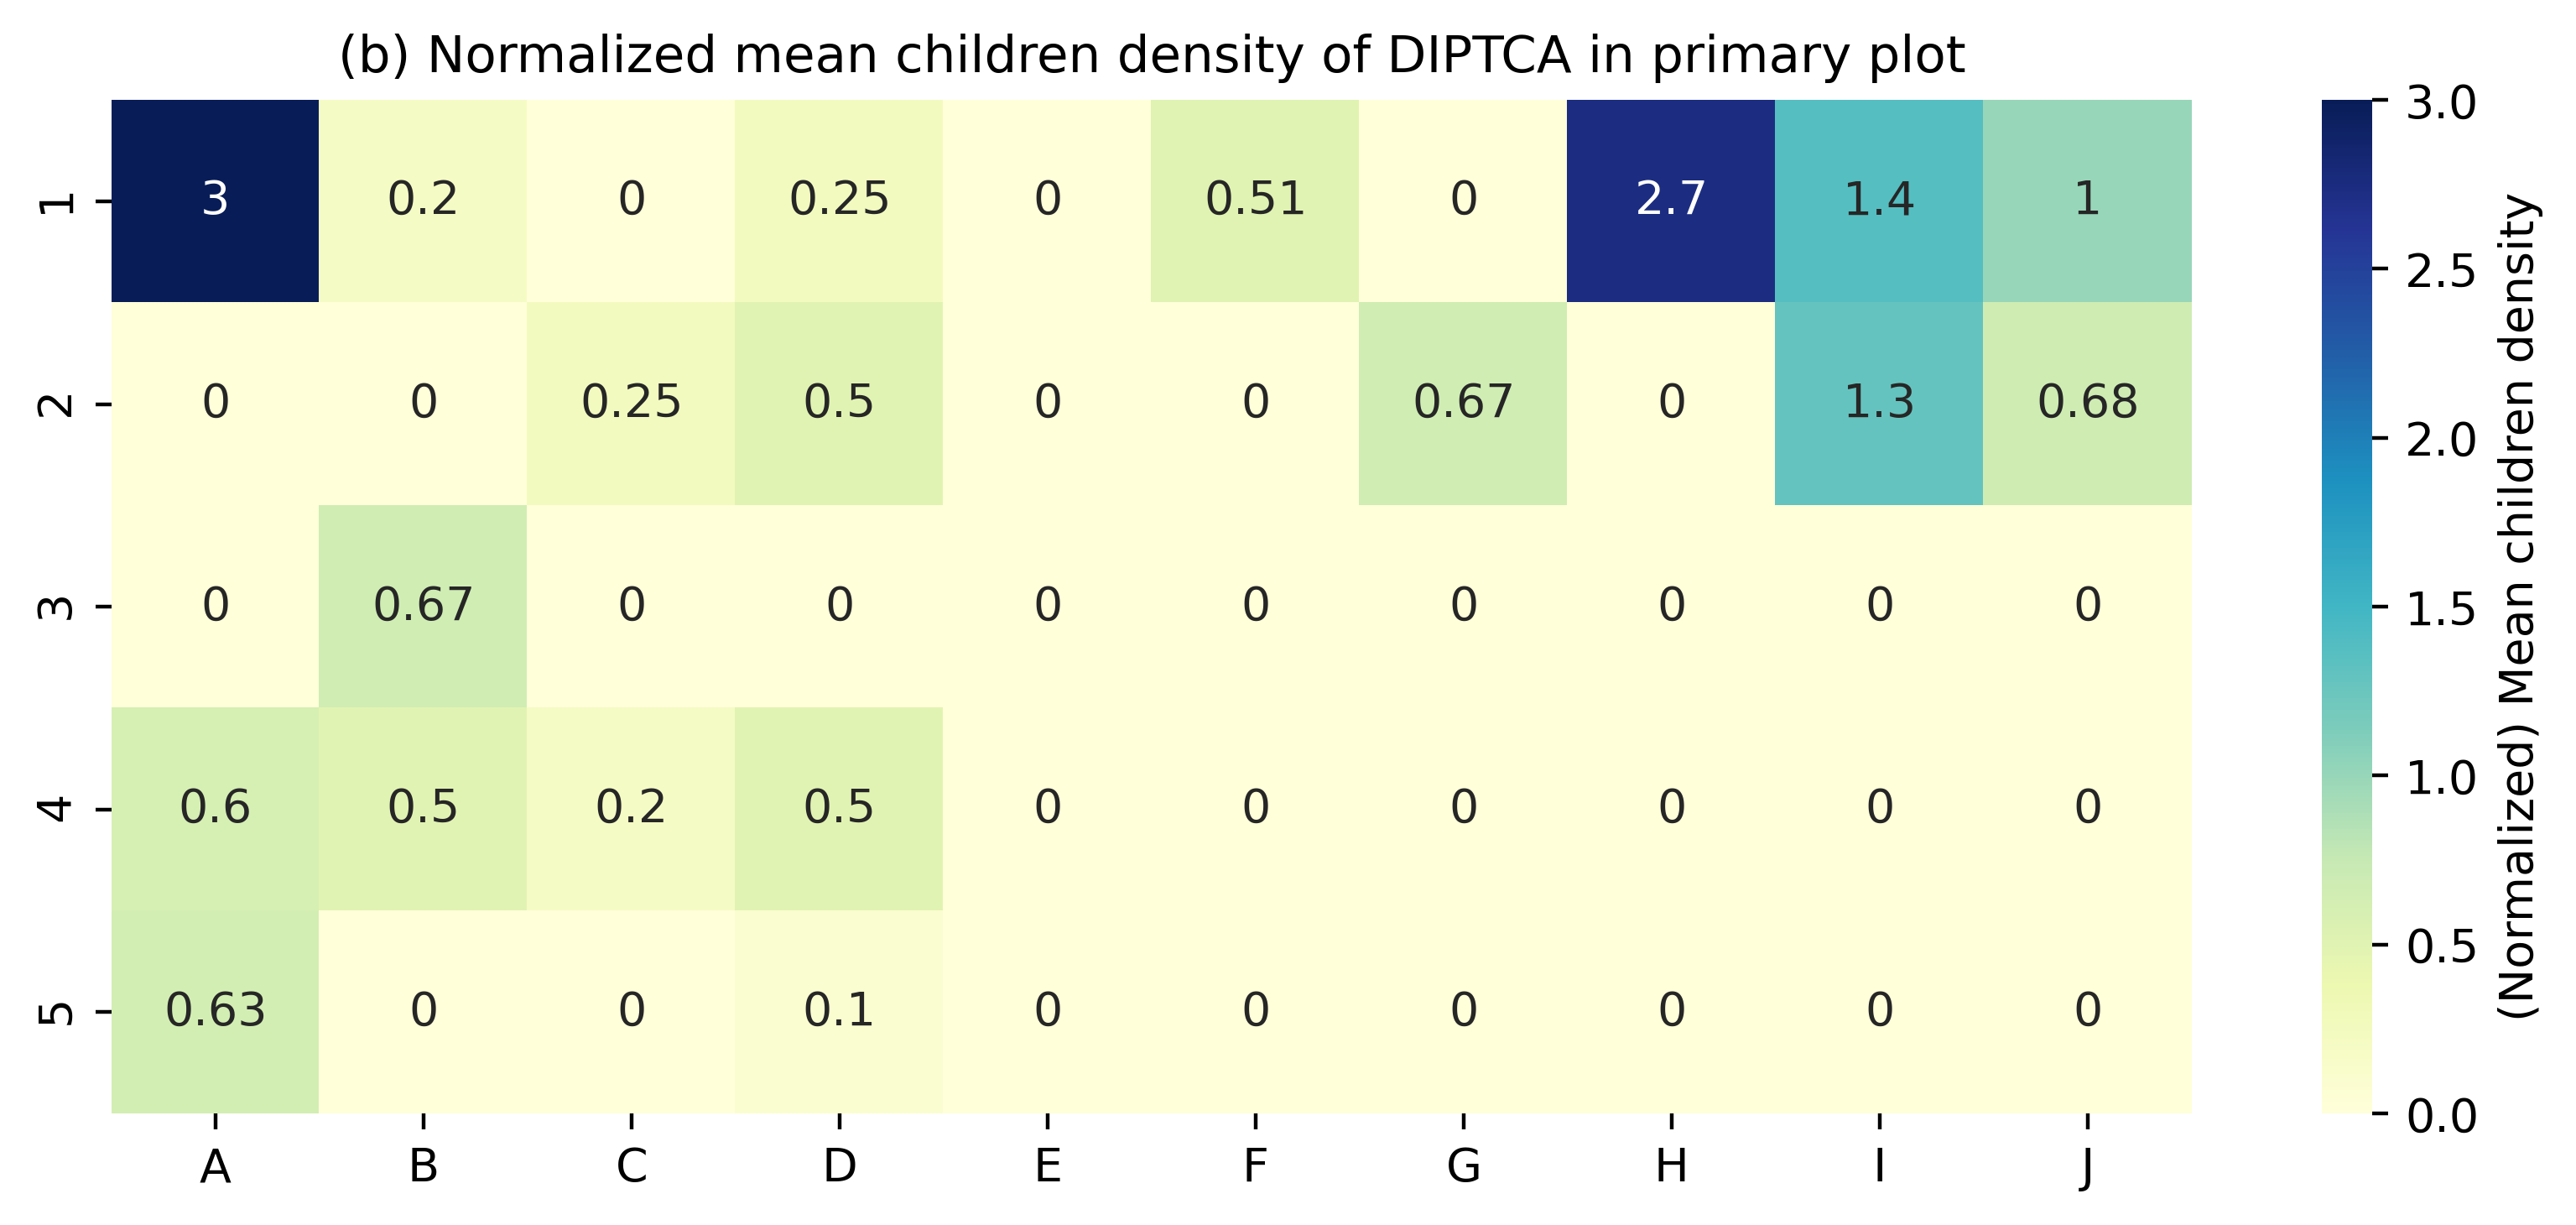

In [24]:
plot_heatmap(primary, 'DIPTCA', 'n20', "(b) Normalized mean children density of DIPTCA in primary plot")

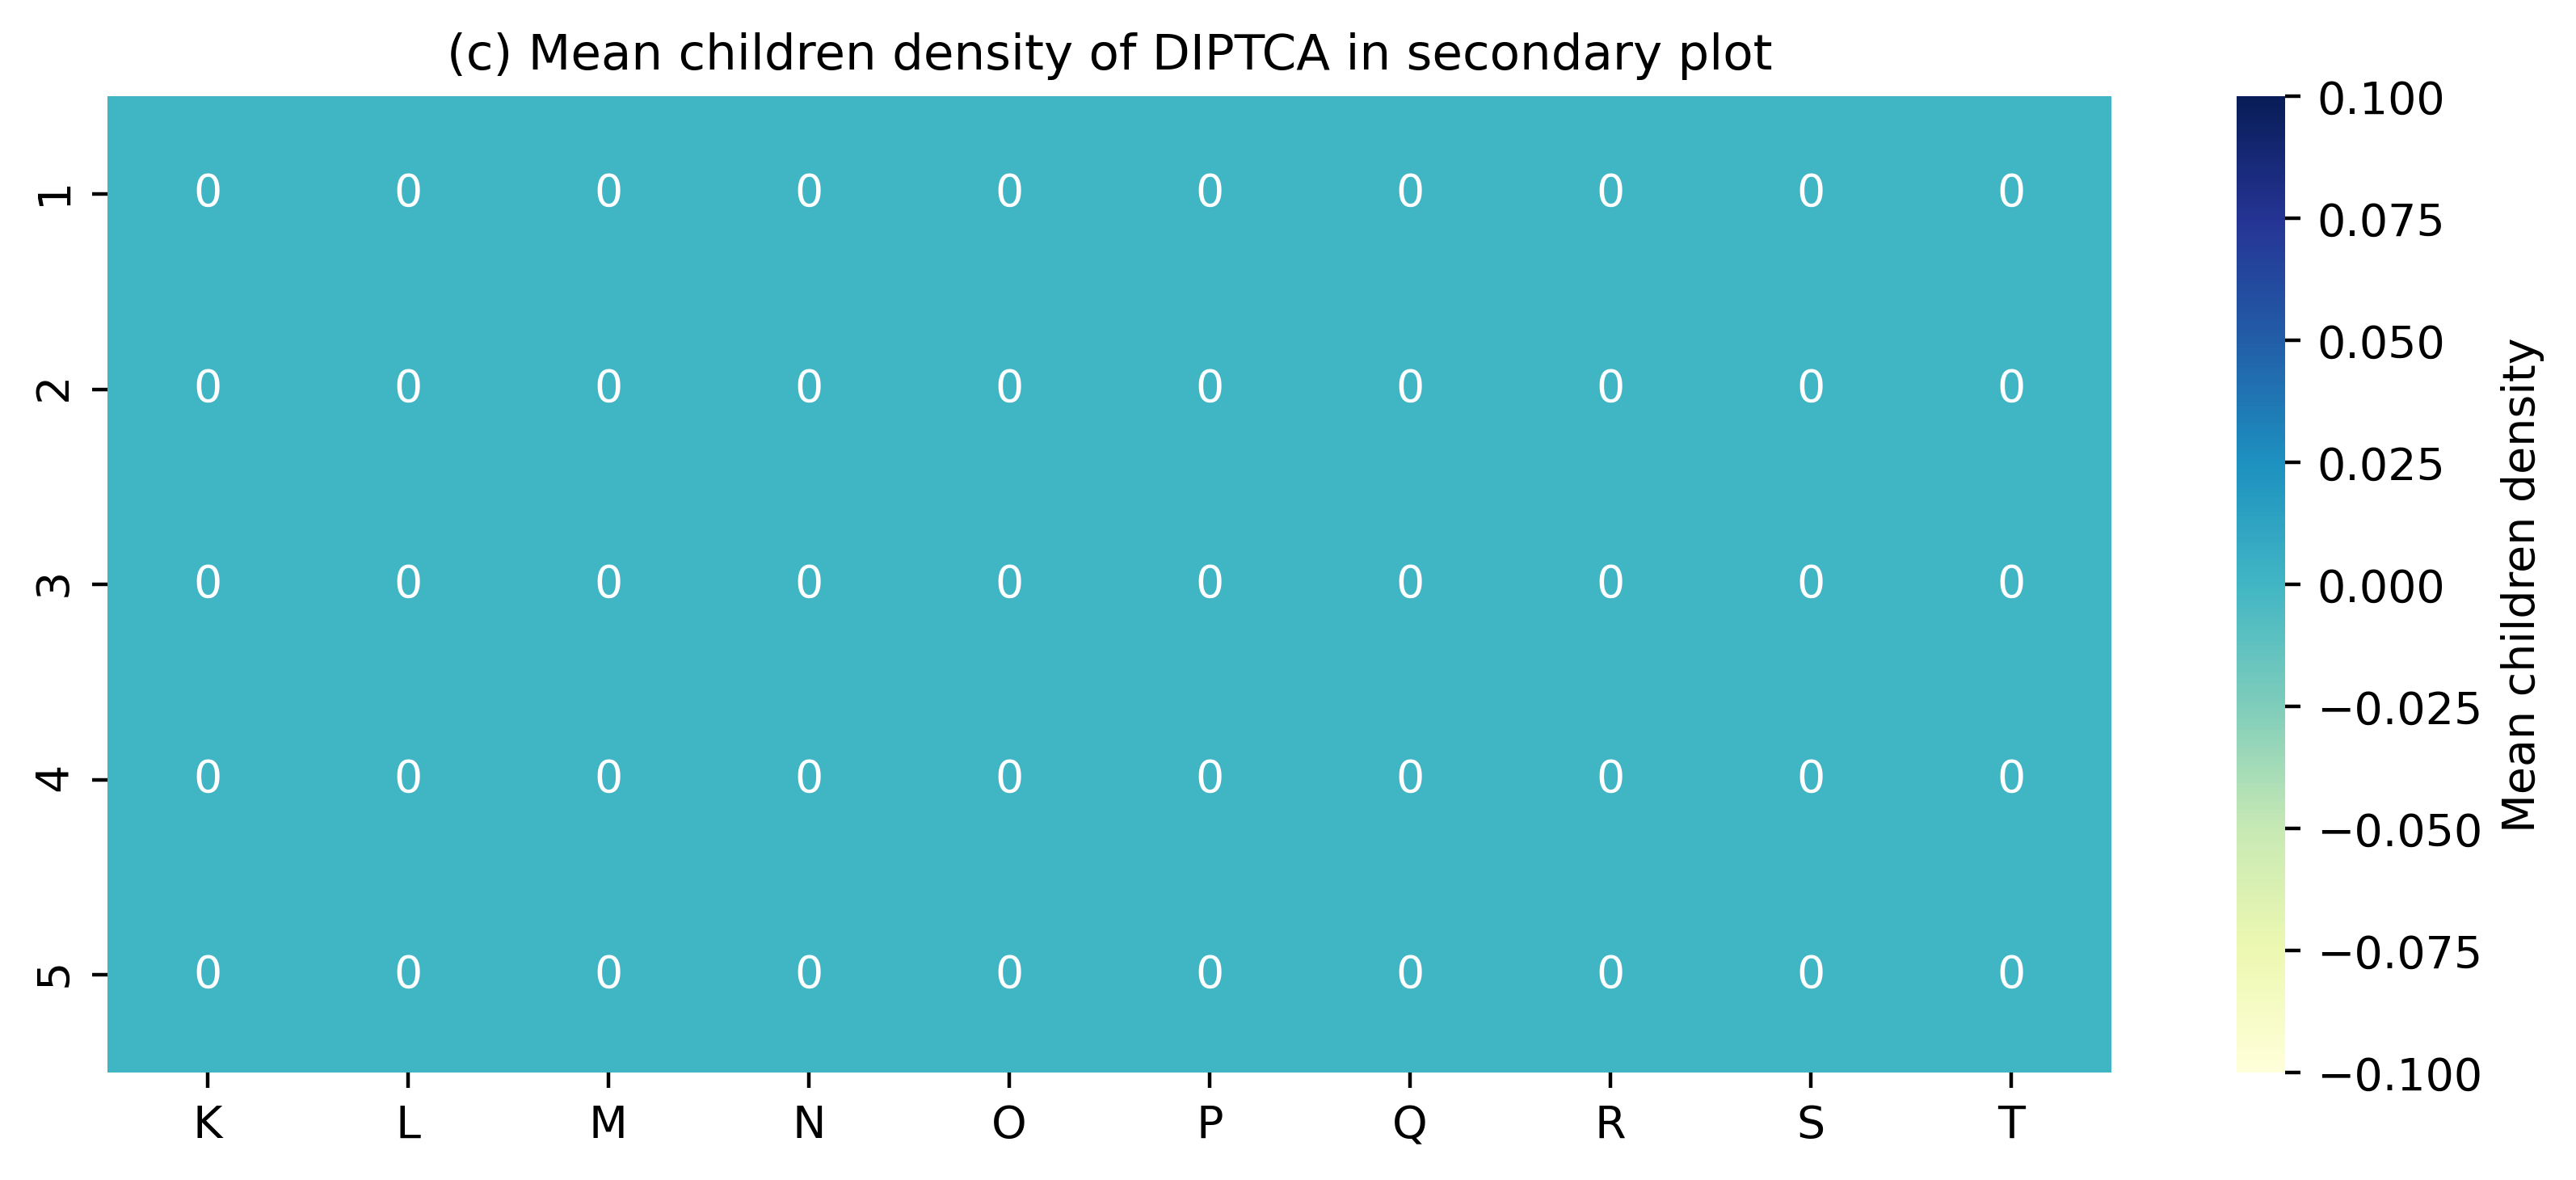

In [25]:
plot_heatmap(secondary, 'DIPTCA', 'c20', "(c) Mean children density of DIPTCA in secondary plot")

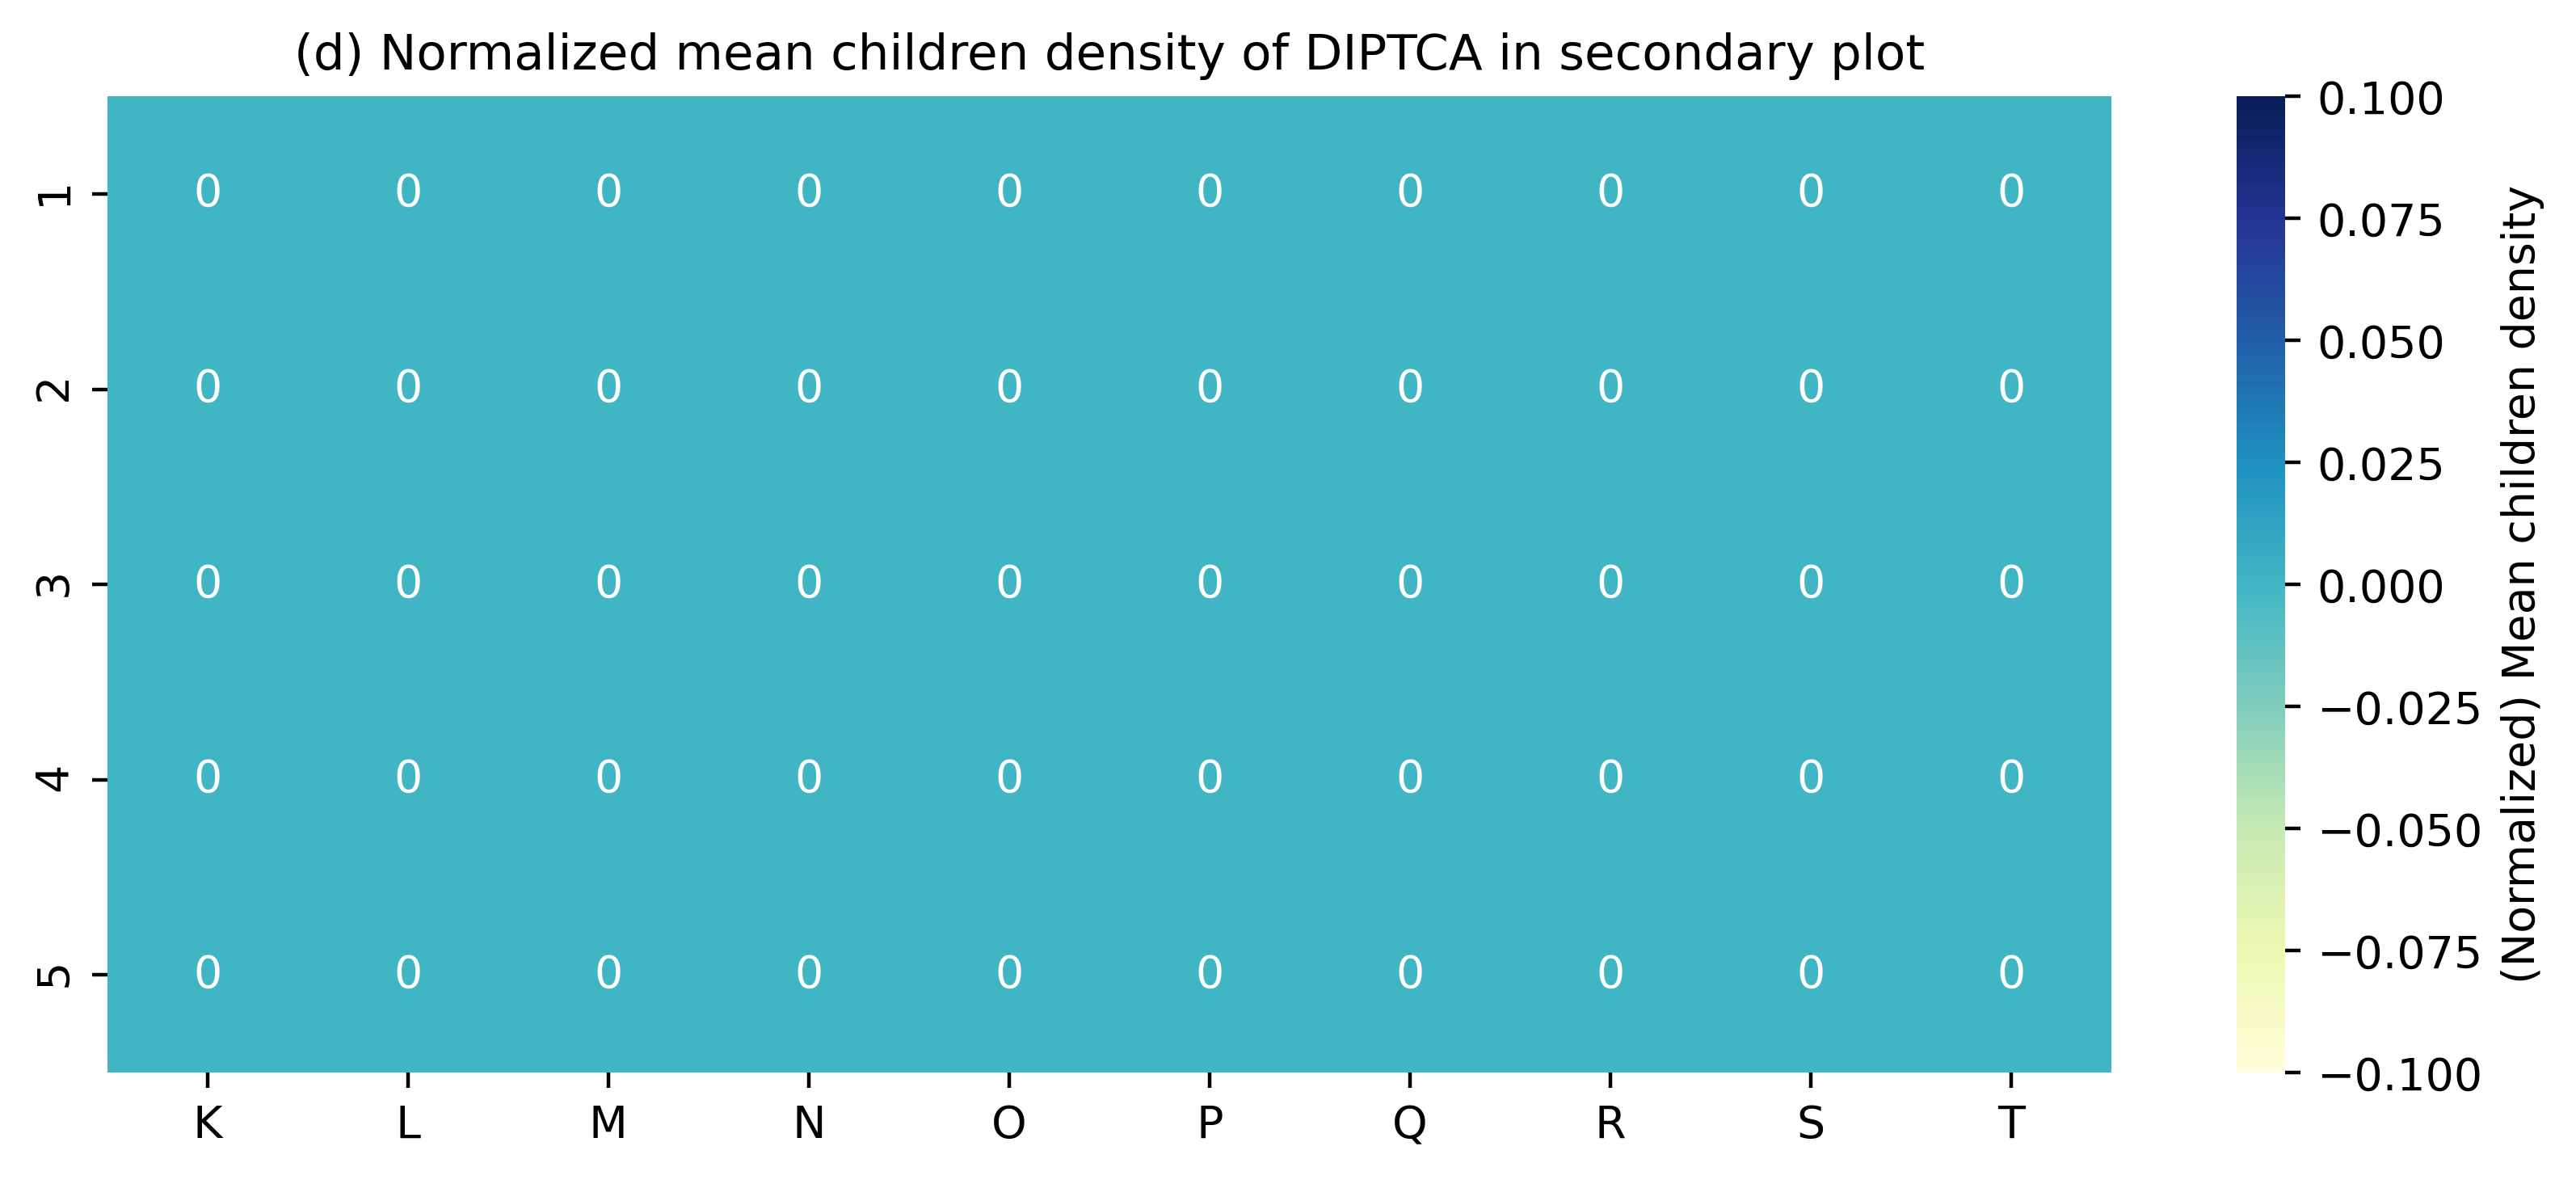

In [26]:
plot_heatmap(secondary, 'DIPTCA', 'n20', "(d) Normalized mean children density of DIPTCA in secondary plot")

## KOOMMA

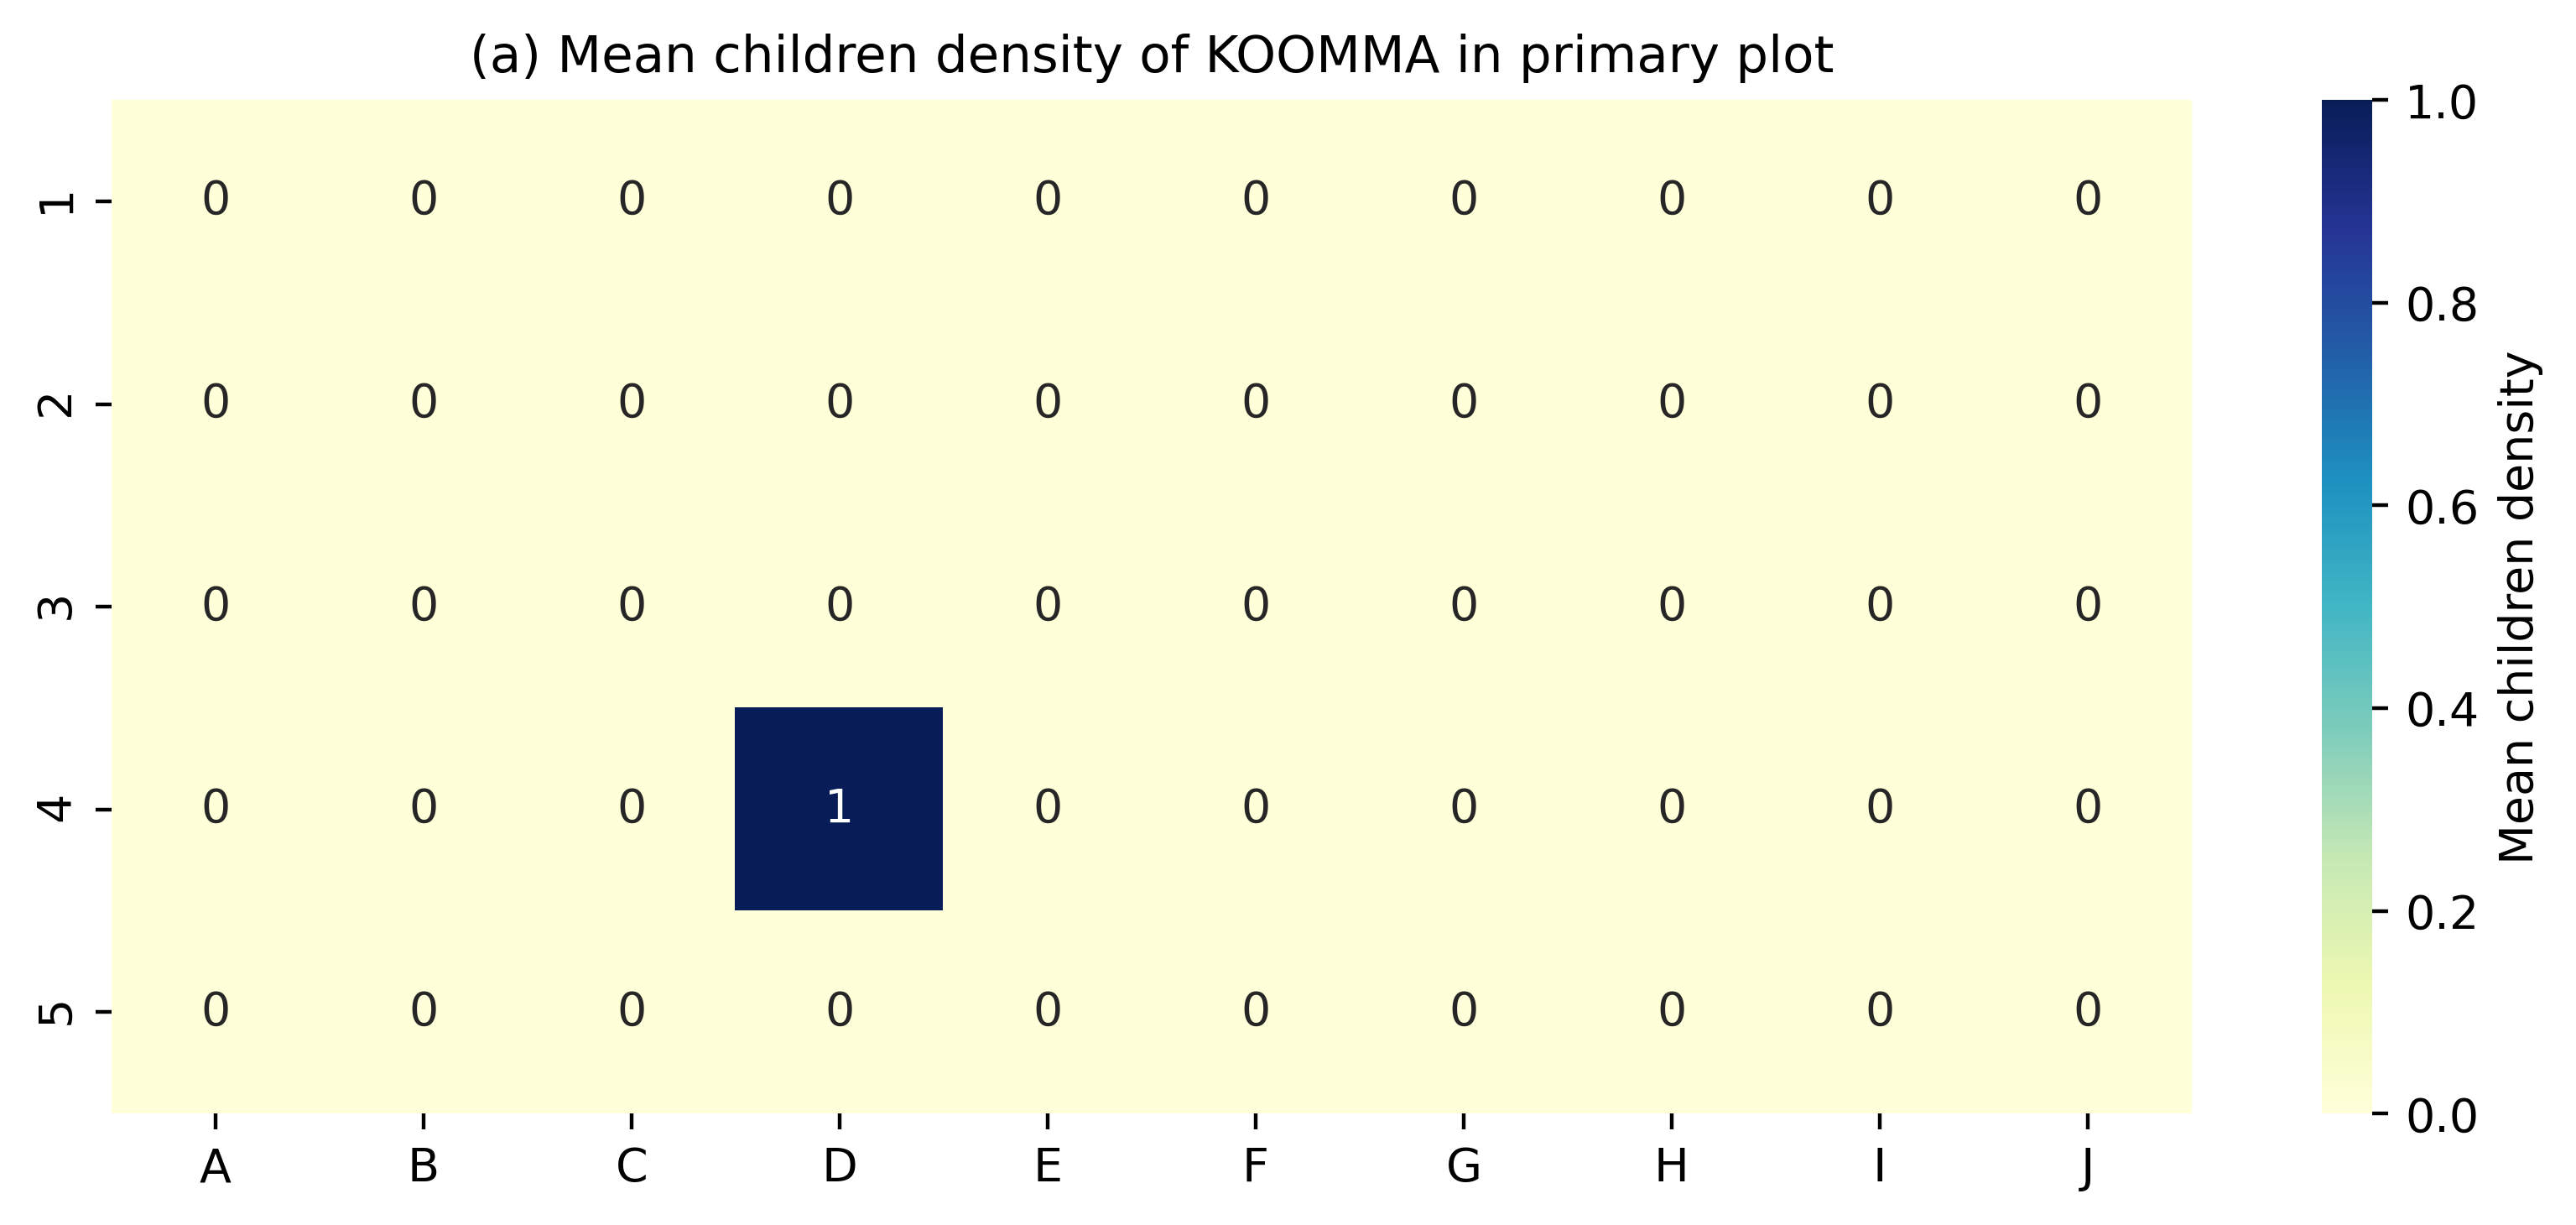

In [31]:
plot_heatmap(primary, 'KOOMMA', 'c20', "(a) Mean children density of KOOMMA in primary plot")

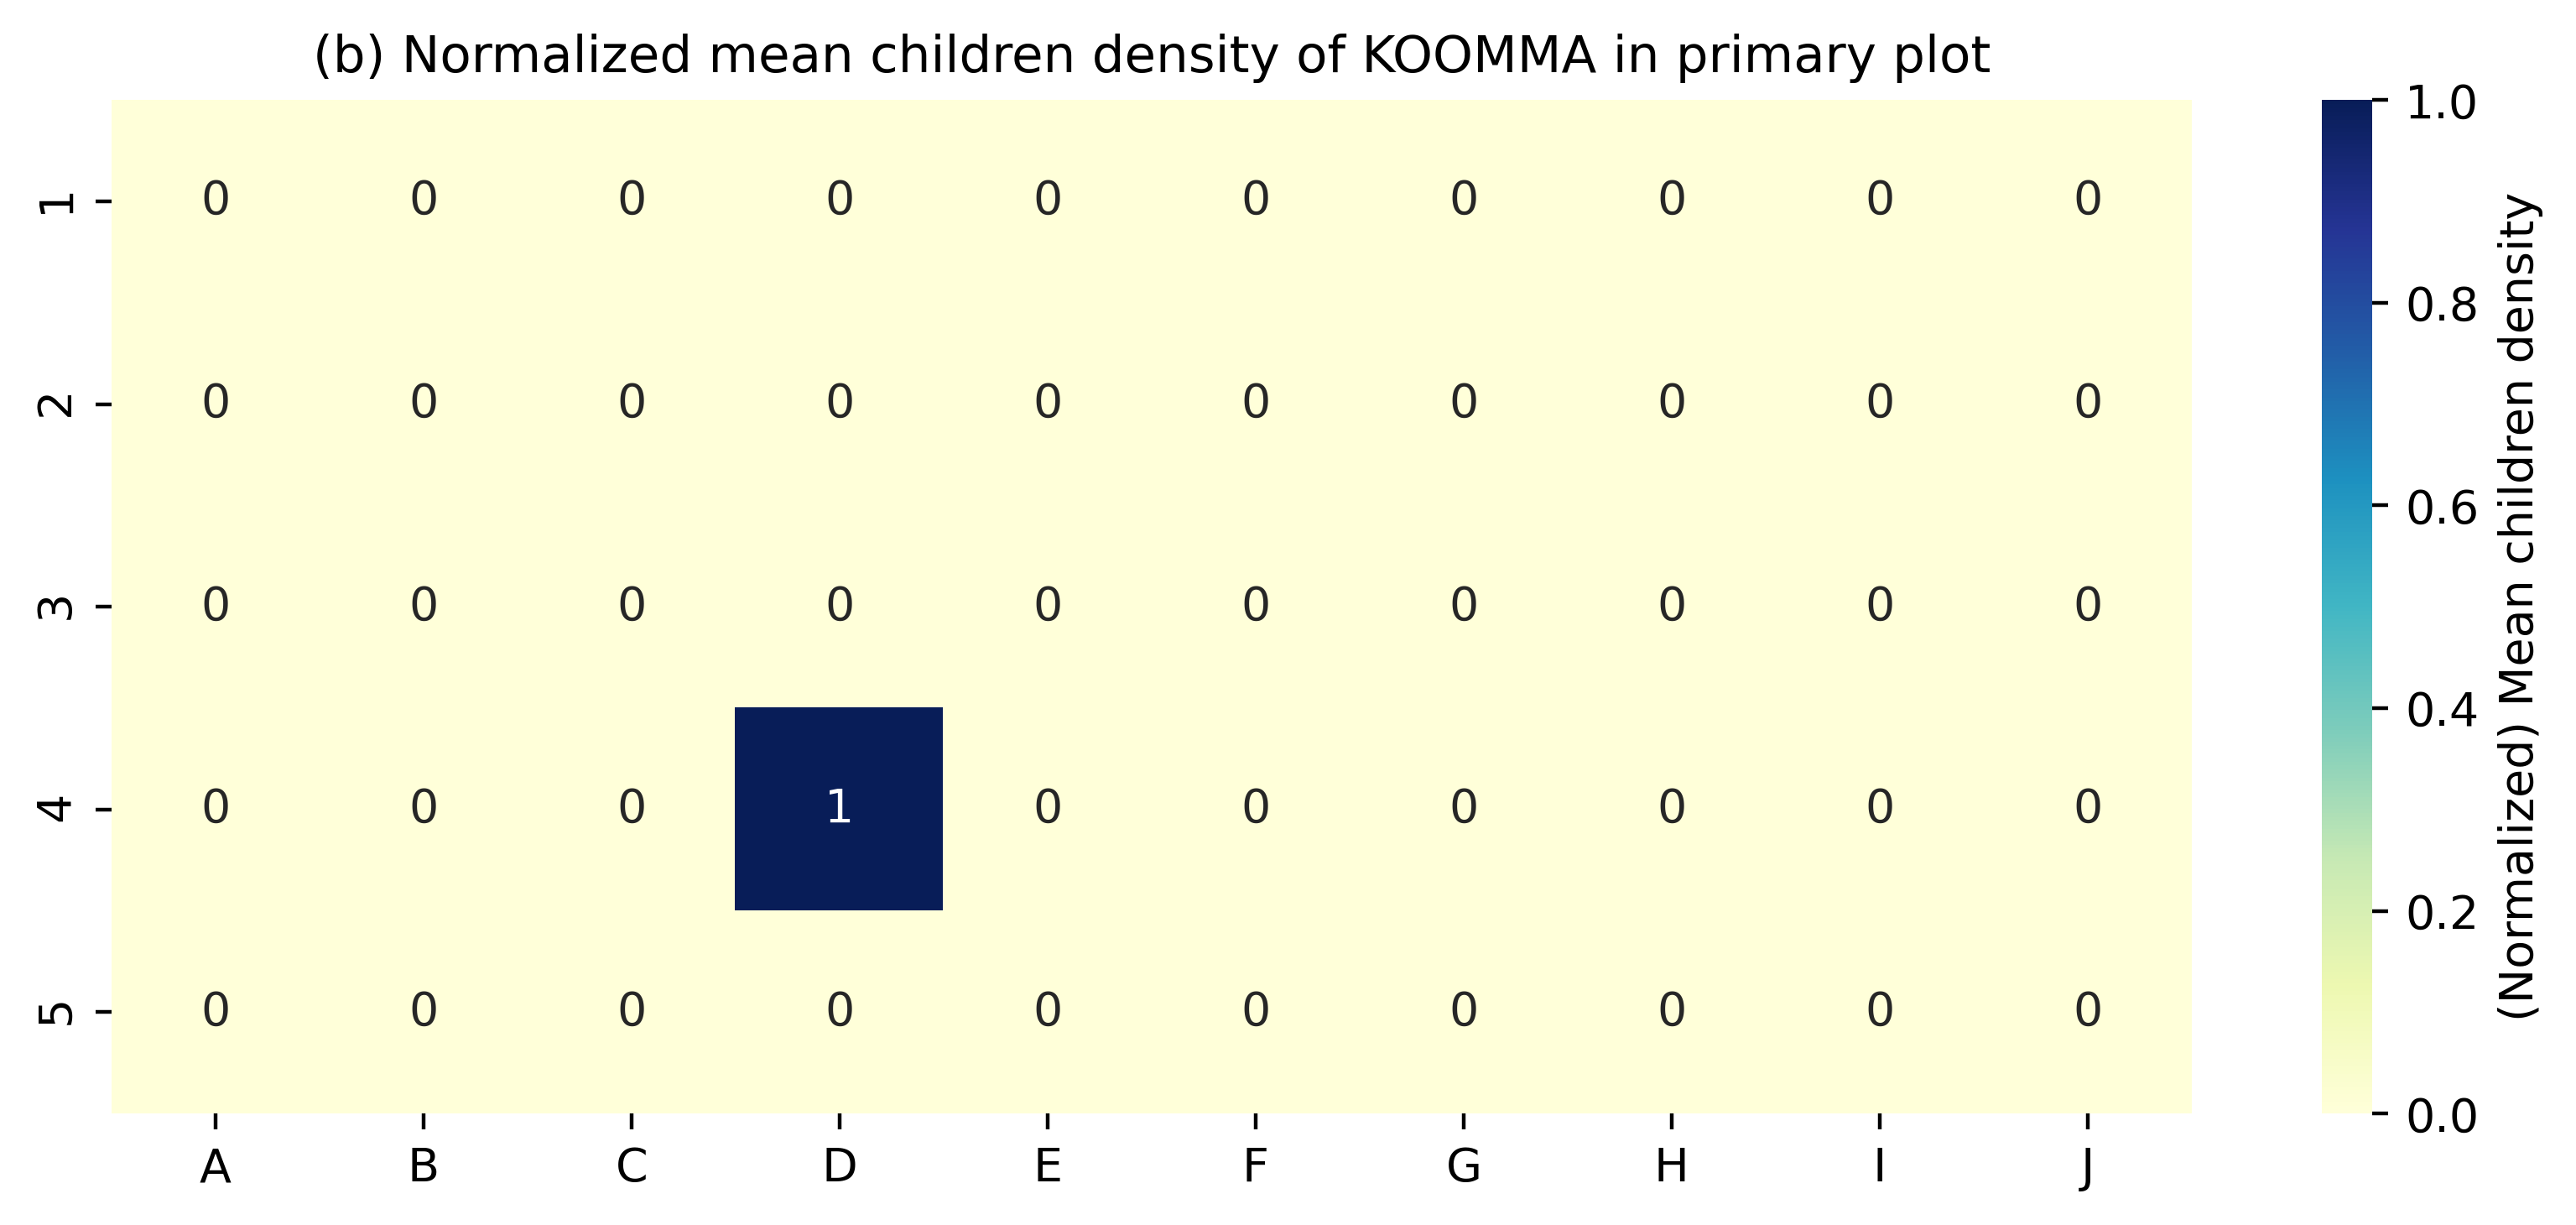

In [32]:
plot_heatmap(primary, 'KOOMMA', 'n20', "(b) Normalized mean children density of KOOMMA in primary plot")

In [35]:
# KOOMMA doesn't exist on secondary plot
# plot_heatmap(secondary, 'KOOMMA', 'c20', "(c) Mean children density of KOOMMA in secondary plot")

In [36]:
# KOOMMA doesn't exist on secondary plot
# plot_heatmap(secondary, 'KOOMMA', 'n20', "(d) Normalized mean children density of KOOMMA in secondary plot")

# Other notes